# TIME SERIES-FURNITURE SALES FORECAST

## IMPORTING LIBRARIES

In [282]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [283]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

## DATA PREPARATION

In [284]:
#LOADING DATASET(CONVERTING xls to xlsx in microsoft excel)
df=pd.read_excel('DS3_C6_S4_TimeSeries_Sales_Data_Project.xlsx')

In [285]:
#SORTING THE ORDER DATE COLUMN
df.sort_values(by=['Order Date'],inplace=True)
df=df.reset_index()
df.drop(['index'],axis=1,inplace=True)
#COPYING ORIGINAL DATAFRAME BEFORE DROPPING COLUMNS
DF=df.copy()
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7981,CA-2014-103800,2014-01-03,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512


In [286]:
#DROPPING THE COLUMNS WHICH ARE NOT NECESSARY FOR ANALYSIS
df.drop(['Row ID','Order ID','Customer ID','Customer Name','Product ID','Country','Ship Date','Ship Mode'],axis=1,inplace=True)
df.head(1)

,Order Date,Segment,City,State,Postal Code,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,2014-01-03,Consumer,Houston,Texas,77095,Central,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512


In [287]:
df.tail(1)

,Order Date,Segment,City,State,Postal Code,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
9993,2017-12-30,Consumer,New York City,New York,10009,East,Furniture,Bookcases,"Bush Westfield Collection Bookcases, Fully Ass...",323.136,4,0.2,12.1176


In [288]:
#DATA TYPES OF THE COLUMN
df.dtypes

Order Date      datetime64[ns]
Segment                 object
City                    object
State                   object
Postal Code              int64
Region                  object
Category                object
Sub-Category            object
Product Name            object
Sales                  float64
Quantity                 int64
Discount               float64
Profit                 float64
dtype: object

In [289]:
#CHECKING FOR NULL VALUES
df.isnull().sum()

Order Date      0
Segment         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Category    0
Product Name    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

In [290]:
#DESCRIBING THE DATASET
df.describe()

,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,55190.379428,229.858001,3.789574,0.156203,28.656896
std,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,90008.000000,209.940000,5.000000,0.200000,29.364000
max,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [291]:
num=df.select_dtypes('number')
print(num.shape)
print(num.columns)
cat=df.select_dtypes('object')
print(cat.shape)
print(cat.columns)
date=df.select_dtypes('datetime')
print(date.shape)
print(date.columns)

(9994, 5)
Index(['Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit'], dtype='object')
(9994, 7)
Index(['Segment', 'City', 'State', 'Region', 'Category', 'Sub-Category',
       'Product Name'],
      dtype='object')
(9994, 1)
Index(['Order Date'], dtype='object')


In [292]:
df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [293]:
#SEPARATING THE CATEGORY COLUMN
df_os=df[df['Category']=='Office Supplies'].reset_index()
df_os.drop(['index'],axis=1,inplace=True)
print(df_os.shape)
df_f=df[df['Category']=='Furniture'].reset_index()
df_f.drop(['index'],axis=1,inplace=True)
print(df_f.shape)
df_t=df[df['Category']=='Technology'].reset_index()
df_t.drop(['index'],axis=1,inplace=True)
print(df_t.shape)

(6026, 13)
(2121, 13)
(1847, 13)


## CATEGORY - OFFICE SUPPLIES

In [294]:
#OUTLIER TREATMENT
Index=[]
def myoutliers(df,col):
    
    Q1=np.quantile(df[col],0.25)
    Q3=np.quantile(df[col],0.75)
    
    IQR=Q3-Q1
    
    global mylist
    global my_outlier_df
    
    UF=Q3+1.5*IQR
    LF=Q1-1.5*IQR
    
    print('LOWER RANGE OF',col,'IS',LF)
    print('UPPER RANGE OF',col,'IS',UF)
    
    mylist=[x for x in df[col] if((x<LF) | (x>UF))]
    print('TOTAL OUTLIERS IN',col,'ARE',len(mylist))
    my_outlier_df=df.loc[df[col].isin(mylist)]
    
    Index.append(my_outlier_df.index)
    

In [295]:
myoutliers(df_os,'Sales')
Index[0]

LOWER RANGE OF Sales IS -90.47999999999999
UPPER RANGE OF Sales IS 182.16
TOTAL OUTLIERS IN Sales ARE 815


Int64Index([   2,    6,   14,   18,   38,   43,   48,   65,   95,  100,
            ...
            5973, 5975, 5981, 5984, 5987, 5997, 6001, 6007, 6019, 6022],
           dtype='int64', length=815)

In [296]:
myoutliers(df_os,'Profit')
Index[1]

LOWER RANGE OF Profit IS -23.8707
UPPER RANGE OF Profit IS 45.38849999999999
TOTAL OUTLIERS IN Profit ARE 1053


Int64Index([   2,    6,   18,   30,   38,   89,   96,  112,  121,  124,
            ...
            5974, 5975, 5985, 5987, 5989, 5991, 5995, 6007, 6019, 6022],
           dtype='int64', length=1053)

In [297]:
#os category sales 
df_os_sales1=df_os.drop(Index[0]).reset_index()
df_os_sales1.drop(['index'],axis=1,inplace=True)
df_os_sales=df_os_sales1[['Sales']]
df_os_sales.index=df_os_sales1['Order Date']
df_os_sales.tail(2)

,Sales
Order Date,
2017-12-30,52.776
2017-12-30,13.904


In [298]:
#os category profit
df_os_profit1=df_os.drop(Index[1]).reset_index()
df_os_profit1.drop(['index'],axis=1,inplace=True)
df_os_profit=df_os_profit1[['Profit']]
df_os_profit.index=df_os_profit1['Order Date']
df_os_profit.tail(2)

,Profit
Order Date,
2017-12-30,19.7910
2017-12-30,4.5188


### SALES

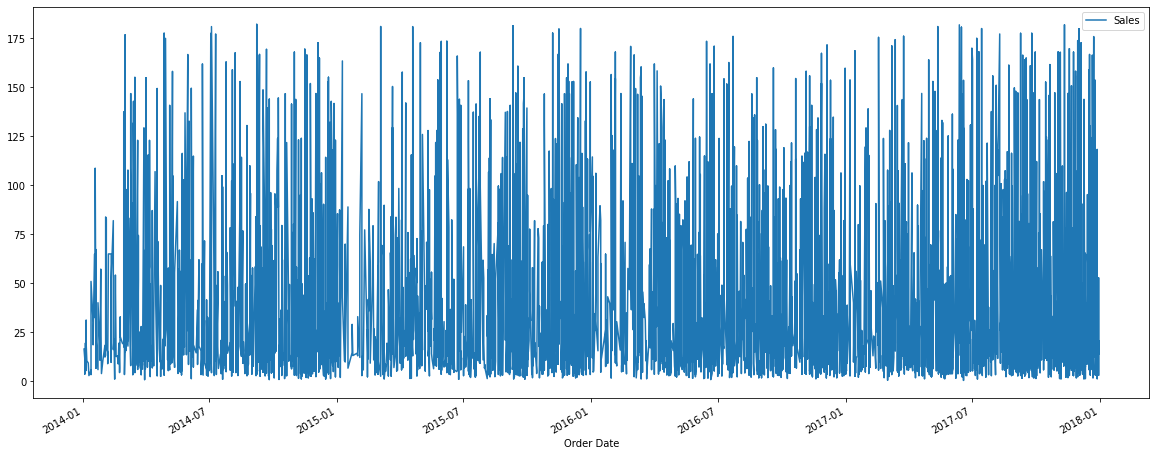

In [299]:
#VISUAL INSPECTION OF DATA
df_os_sales.plot(figsize=(20,8))
plt.show()

In [300]:
#AS THE DATA IS LARGE, WE ARE SAMPLING THE DATA FOR 7 DAYS
df1_os_sales=df_os_sales.resample('M').mean()
print(df1_os_sales.shape)
df1_os_sales.head(2)

(48, 1)


,Sales
Order Date,
2014-01-31,25.636233
2014-02-28,27.770133


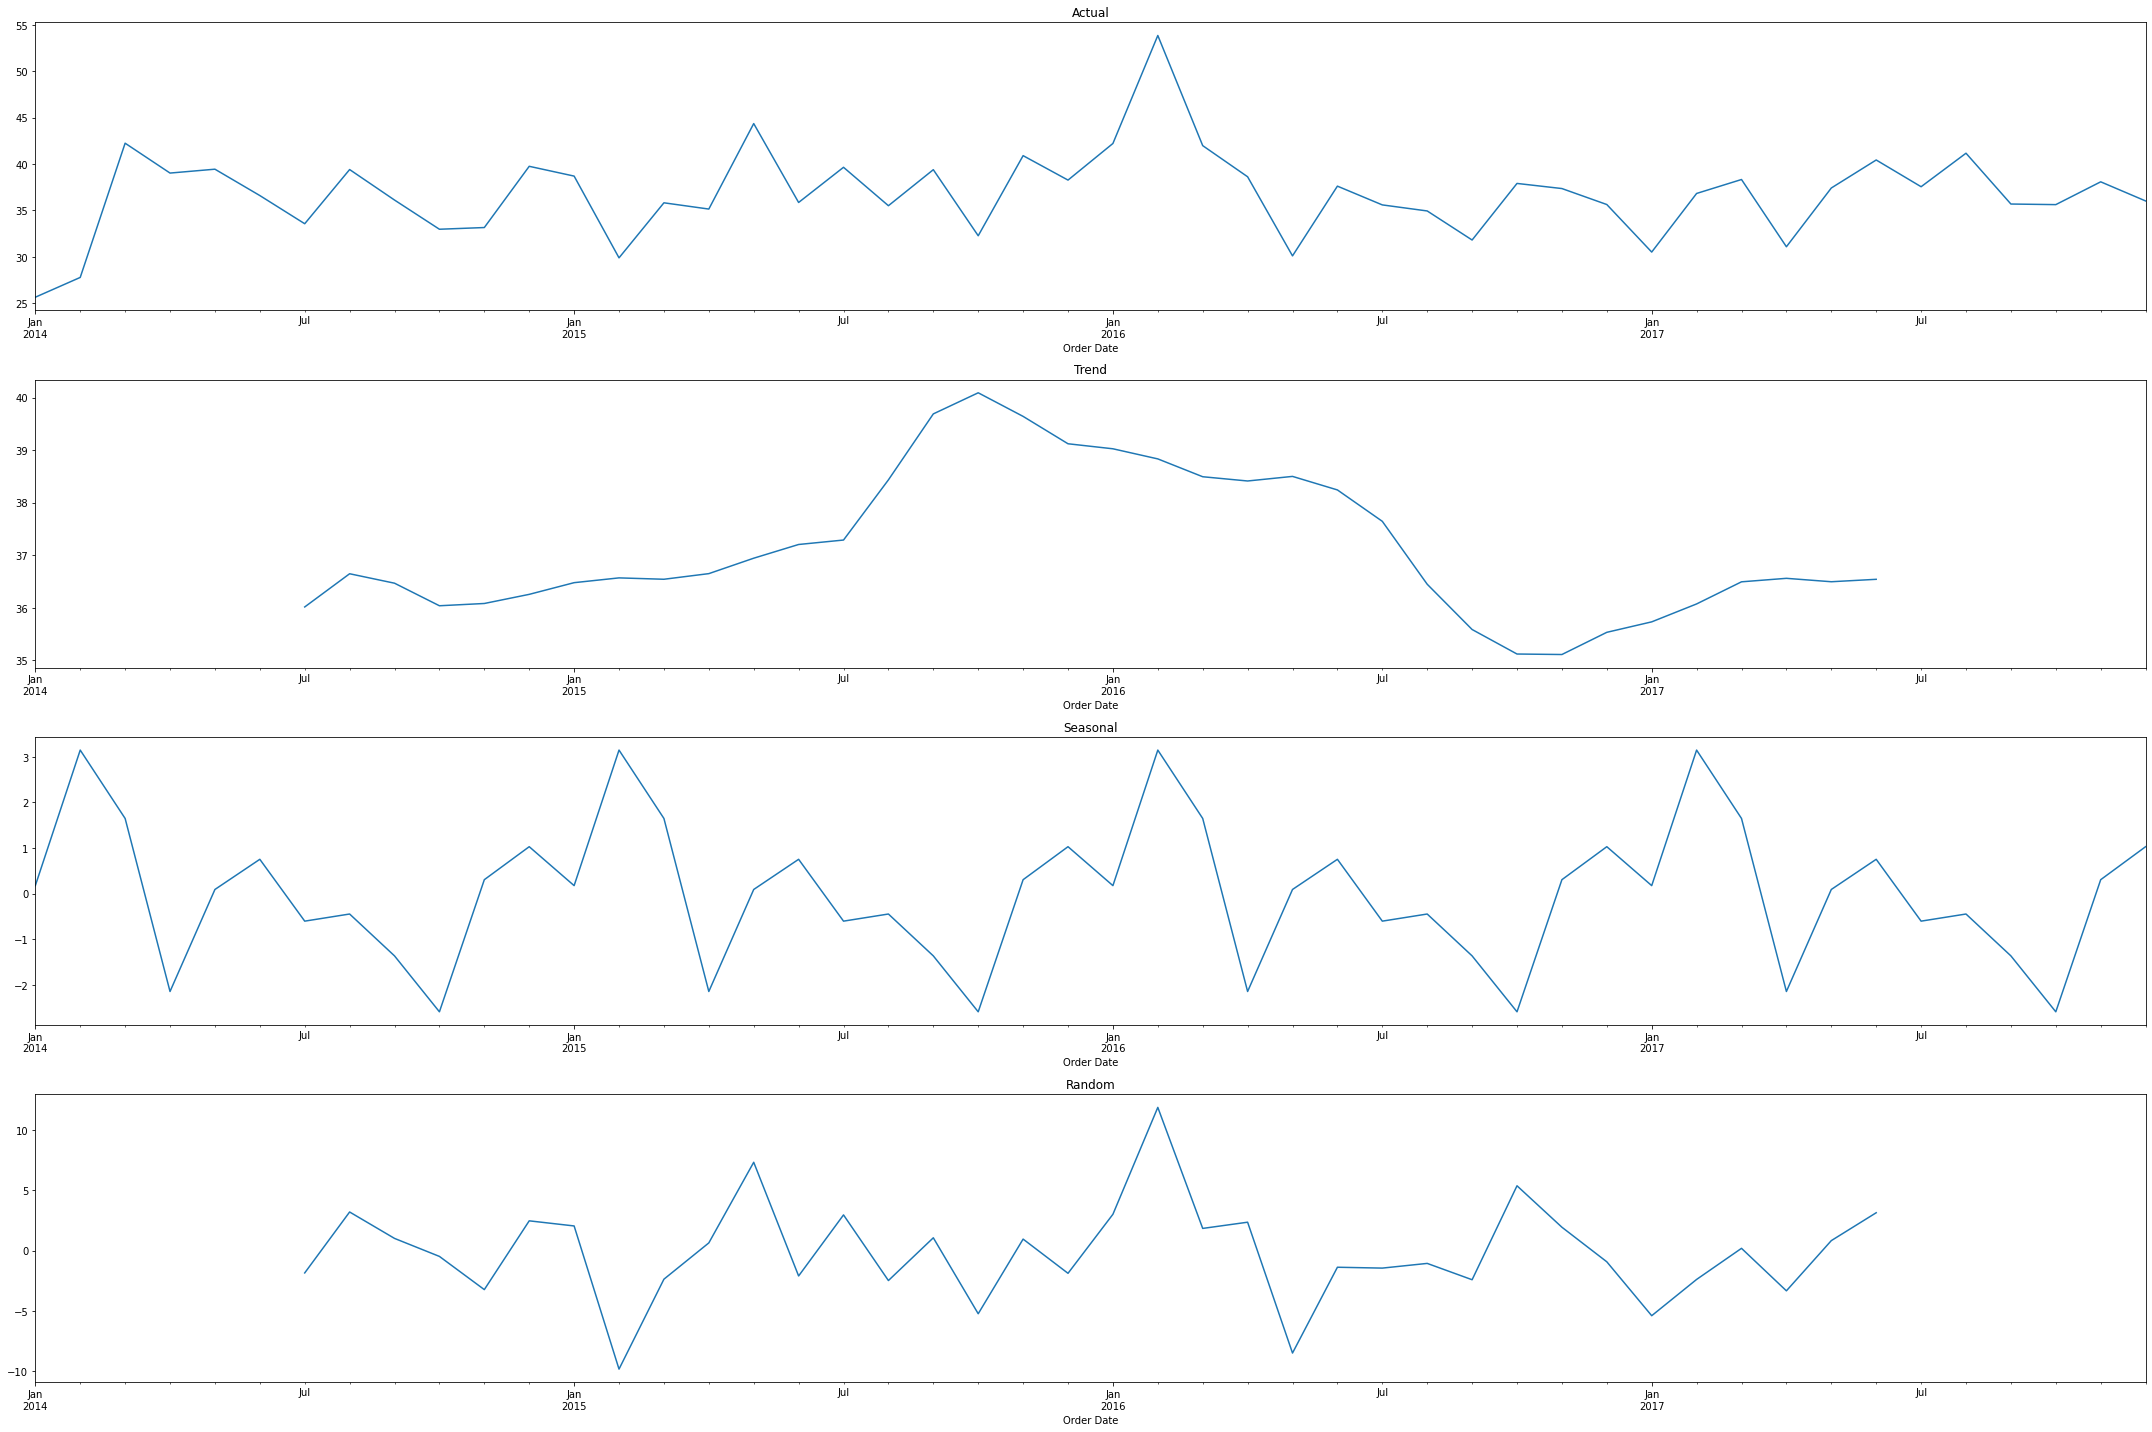

In [301]:
#DECOMPOSITION OF DATA
fig,ax = plt.subplots(4,1,figsize=(30,20))

result = seasonal_decompose(df1_os_sales, period=12)

result.observed.plot(ax=ax[0])
ax[0].set_title("Actual")

result.trend.plot(ax=ax[1])
ax[1].set_title("Trend")

result.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonal")

result.resid.plot(ax=ax[3])
ax[3].set_title("Random")

fig.tight_layout()

plt.show()

There is no trend in data but there is seasonality.

##### SPLITTING DATASET INTO 70 % TRAIN AND 30 % TEST

In [302]:
split= int(round(0.7 * len(df1_os_sales),0))
train_df1=df1_os_sales.iloc[:split]
test_df1=df1_os_sales.iloc[split:]
print(train_df1.shape,test_df1.shape)
train_df1.head(2),test_df1.head(2)

(34, 1) (14, 1)


(                Sales
 Order Date           
 2014-01-31  25.636233
 2014-02-28  27.770133,
                 Sales
 Order Date           
 2016-11-30  37.352984
 2016-12-31  35.630226)

#### CHECKING FOR STATIONARITY

In [303]:
# Augmented dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [304]:
#TRAINING
r=checkStationarity(train_df1)
print('TRAINING:\n',r)

#TESTING
r=checkStationarity(test_df1)
print(r)
# difference in the data 
diff = test_df1 - test_df1.shift()
print(diff)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff))
diff.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff))
print(diff)
# checking again the differenced data for stationarity
checkStationarity(diff)

TRAINING:
 p-value=4.4766816857506086e-05. Data is stationary
p-value=0.3055148284757888. Data is not stationary
               Sales
Order Date          
2016-11-30       NaN
2016-12-31 -1.722758
2017-01-31 -5.125893
2017-02-28  6.319422
2017-03-31  1.503947
2017-04-30 -7.250198
2017-05-31  6.334937
2017-06-30  3.020208
2017-07-31 -2.883089
2017-08-31  3.613403
2017-09-30 -5.478871
2017-10-31 -0.064450
2017-11-30  2.458643
2017-12-31 -2.062713
Before removing Nulls,total records =  14
After removing Nulls, total records =  13
               Sales
Order Date          
2016-12-31 -1.722758
2017-01-31 -5.125893
2017-02-28  6.319422
2017-03-31  1.503947
2017-04-30 -7.250198
2017-05-31  6.334937
2017-06-30  3.020208
2017-07-31 -2.883089
2017-08-31  3.613403
2017-09-30 -5.478871
2017-10-31 -0.064450
2017-11-30  2.458643
2017-12-31 -2.062713


'p-value=1.5918636700783267e-08. Data is stationary'

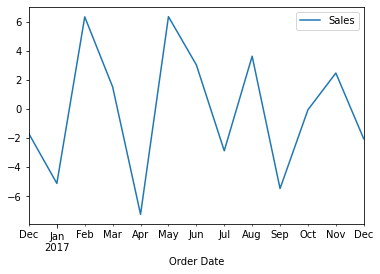

In [305]:
#PLOTTING THE DIFFERENCED DATA FOR TEST DATA
diff.plot()
plt.show()

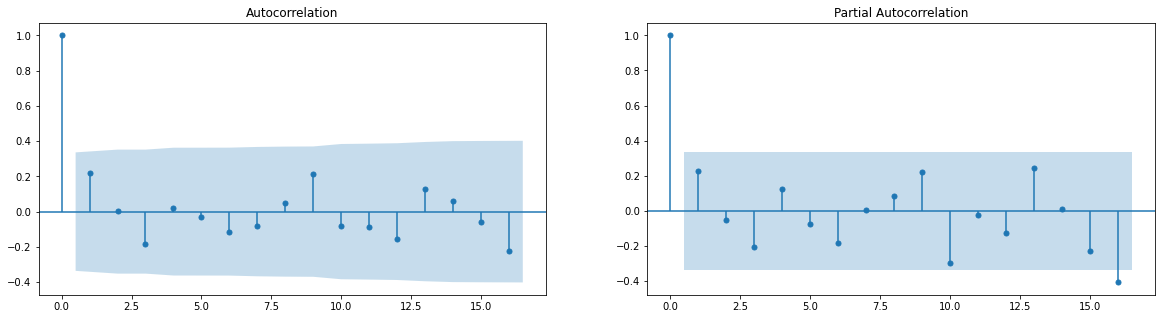

In [306]:
#plotting ACF and PACF plots
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(train_df1,ax=ax[0])
plot_pacf(train_df1,ax=ax[1])
plt.show()

#### SARIMA MODEL

In [307]:
#FINDING THE BEST P,Q,D VALUES
aic=[]
llf=[]
for p in range(0,3):
    for q in range(0,3):
        for d in range(0,2):
            print(p,d,q)
            m1 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
            aic.append(m1.aic)
            llf.append(m1.llf)
            m1.summary()
            print('AIC=',m1.aic,'LLR=',m1.llf)      

0 0 0
AIC= 344.5721826974232 LLR= -171.2860913487116
0 1 0
AIC= 160.1174198595672 LLR= -79.0587099297836
0 0 1
AIC= 299.8722580531292 LLR= -146.9361290265646
0 1 1
AIC= 154.6108344786511 LLR= -74.30541723932555
0 0 2
AIC= 268.27343582353546 LLR= -129.13671791176773
0 1 2
AIC= 158.31378886845508 LLR= -74.15689443422754
1 0 0
AIC= 226.48448356730194 LLR= -110.24224178365097
1 1 0
AIC= 157.9425131245423 LLR= -75.97125656227115
1 0 1
AIC= 220.59675800061507 LLR= -105.29837900030753
1 1 1
AIC= 158.25527824631519 LLR= -74.12763912315759
1 0 2
AIC= 222.7627468014022 LLR= -104.3813734007011
1 1 2
AIC= 162.41935783821094 LLR= -74.20967891910547
2 0 0
AIC= 220.52411031787946 LLR= -105.26205515893973
2 1 0
AIC= 161.8676551187393 LLR= -75.93382755936965
2 0 1
AIC= 220.55628841874668 LLR= -103.27814420937334
2 1 1
AIC= 162.21409080650213 LLR= -74.10704540325106
2 0 2
AIC= 225.9951977986847 LLR= -103.99759889934235
2 1 2
AIC= 164.99157976120102 LLR= -73.49578988060051


In [308]:
max(llf) #-->2,1,0

-73.49578988060051

In [309]:
min(aic) #-->0,1,1

154.6108344786511

Comparison of SARIMA Models:-
    
We choose p=2,d=0,q=0

In [310]:
#PUTTING P,D,Q VALUES
p,d,q=2,0,0
m1 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   34
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -105.262
Date:                            Tue, 24 May 2022   AIC                            220.524
Time:                                    22:19:39   BIC                            228.156
Sample:                                01-31-2014   HQIC                           223.127
                                     - 10-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6696      0.268      2.495      0.013       0.144       1.196
ar.L2          0.3295      0.269   

In [311]:
#PREDICTING THE VALUES
predictions = m1.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31     0.000000
2014-02-28    25.264317
2014-03-31    26.804990
2014-04-30    37.152231
2014-05-31    39.758248
2014-06-30    38.977451
2014-07-31    37.219493
2014-08-31    34.258118
2014-09-30    37.157128
2014-10-31    36.871288
2014-11-30    33.727041
2014-12-31    32.707017
2015-01-31    37.534494
2015-02-28    37.911116
2015-03-31    25.945539
Freq: M, Name: predicted_mean, dtype: float64


In [312]:
# actual vs predicted values
actual1 = []; pred1 = []

for i in range(len(test_df1)):
    actual1.append(test_df1.iloc[i][0])
    pred1.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual1, 'predicted':pred1})
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

       actual  predicted        err
0   37.352984   0.000000  37.352984
1   35.630226  25.264317  10.365909
2   30.504333  26.804990   3.699344
3   36.823755  37.152231  -0.328476
4   38.327702  39.758248  -1.430546
5   31.077504  38.977451  -7.899946
6   37.412441  37.219493   0.192948
7   40.432649  34.258118   6.174531
8   37.549560  37.157128   0.392431
9   41.162963  36.871288   4.291675
10  35.684092  33.727041   1.957051
11  35.619642  32.707017   2.912625
12  38.078285  37.534494   0.543791
13  36.015572  37.911116  -1.895544


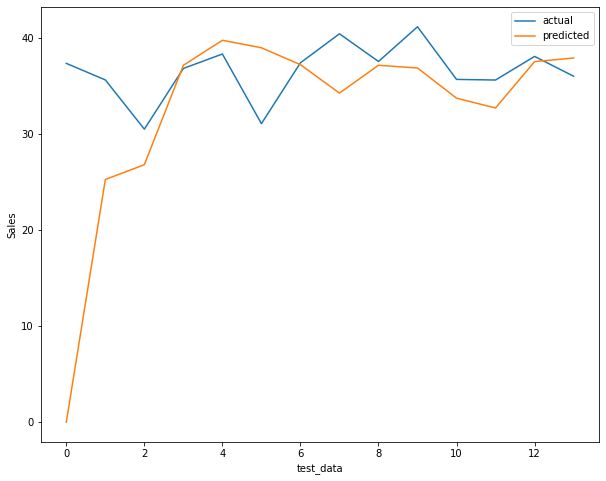

In [313]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res1.actual.plot(figsize=(10,8),legend=True)
plt.xlabel('test_data')
plt.ylabel('Sales')
df_res1.predicted.plot(legend=True)
plt.show()

In [314]:
mse1 = mean_squared_error(df_res1.actual,df_res1.predicted)
rmse1=np.sqrt(mse1)
rmse1,mse1

(10.868969395171657, 118.13449571317815)

In [315]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [316]:
fcast1=m1.forecast(len(test_df1))
fcast1

2016-11-30    31.875712
2016-12-31    29.531842
2017-01-31    27.349500
2017-02-28    24.440119
2017-03-31    29.164016
2017-04-30    31.903114
2017-05-31    32.226520
2017-06-30    32.066597
2017-07-31    31.109174
2017-08-31    34.064510
2017-09-30    33.839418
2017-10-31    33.834717
2017-11-30    32.739381
2017-12-31    35.968045
Freq: M, Name: predicted_mean, dtype: float64

In [317]:
mse11 = mean_squared_error(test_df1,fcast1)
rmse11=np.sqrt(mse11)
rmse11,mse11

(6.204831921909096, 38.499939179142125)

In [318]:
#FORCASTING THE FUTURE DATA
fcast1 = m1.predict(start=len(df1_os_sales)-1, end=len(df1_os_sales)+len(test_df1), typ='levels').rename('Forecasted Sales')
print(fcast1)

2017-12-31    35.968045
2018-01-31    35.028622
2018-02-28    29.865927
2018-03-31    33.766909
2018-04-30    33.830828
2018-05-31    38.796027
2018-06-30    34.220632
2018-07-31    36.088469
2018-08-31    34.333554
2018-09-30    36.365035
2018-10-31    32.553262
2018-11-30    36.985858
2018-12-31    36.078670
2019-01-31    38.031787
2019-02-28    43.431548
2019-03-31    37.694963
Freq: M, Name: Forecasted Sales, dtype: float64


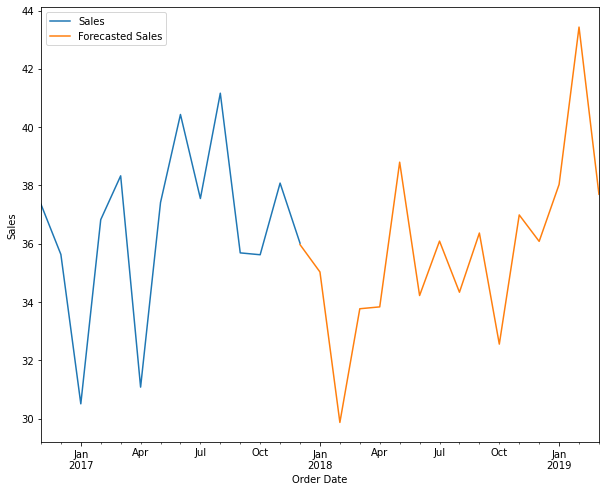

In [319]:
#VISUALIZING THE FORECASTED DATA
test_df1.plot(figsize=(10,8),legend=True)
plt.ylabel('Sales')
fcast1.plot(legend=True)
plt.show()

### PROFIT

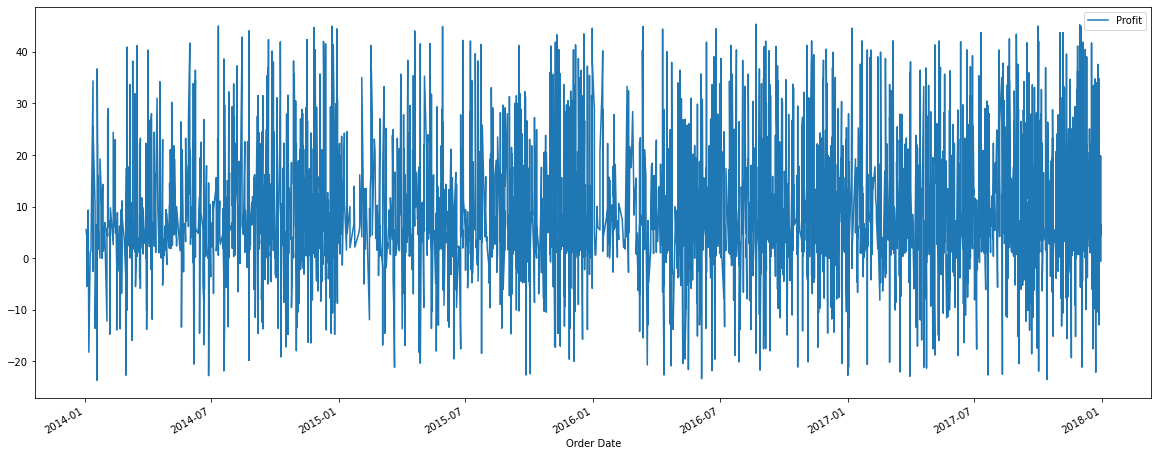

In [320]:
#VISUAL INSPECTION OF DATA
df_os_profit.plot(figsize=(20,8))
plt.show()

In [321]:
#AS THE DATA IS LARGE, WE ARE SAMPLING THE DATA FOR 7 DAYS
df1_os_profit=df_os_profit.resample('M').mean()
print(df1_os_profit.shape)
df1_os_profit.head(2)

(48, 1)


,Profit
Order Date,
2014-01-31,6.633671
2014-02-28,5.680355


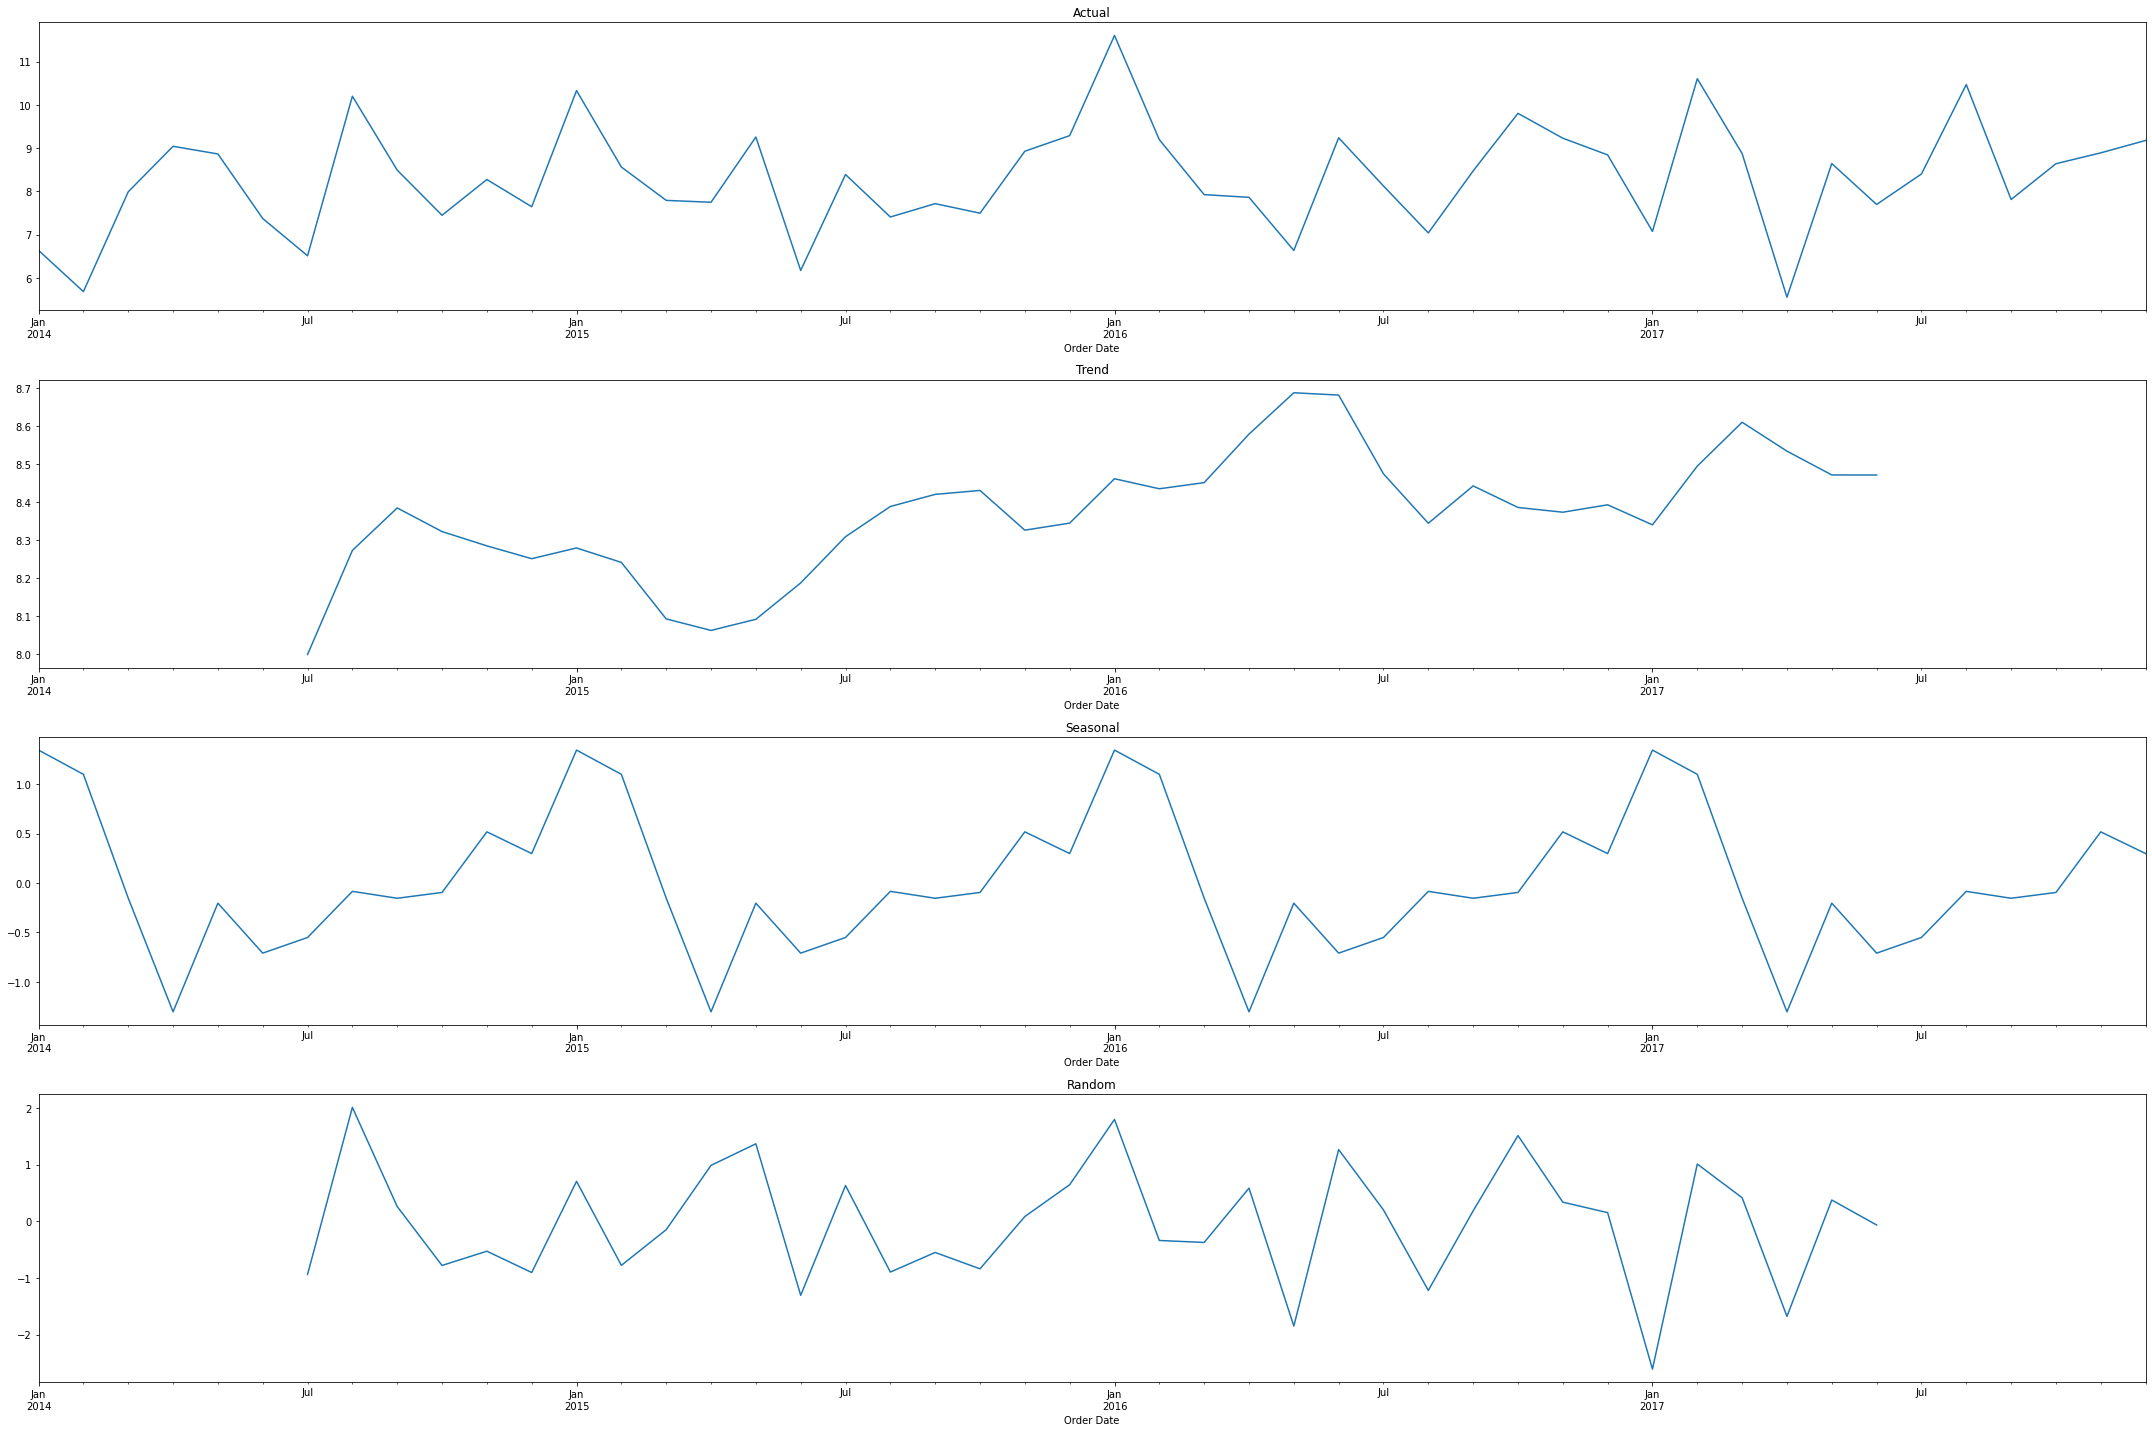

In [322]:
#DECOMPOSITION OF DATA
fig,ax = plt.subplots(4,1,figsize=(30,20))

result = seasonal_decompose(df1_os_profit, period=12)

result.observed.plot(ax=ax[0])
ax[0].set_title("Actual")

result.trend.plot(ax=ax[1])
ax[1].set_title("Trend")

result.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonal")

result.resid.plot(ax=ax[3])
ax[3].set_title("Random")

fig.tight_layout()

plt.show()

There is increasing trend and seasonality in data.

##### SPLITTING DATASET INTO 70 % TRAIN AND 30 % TEST

In [323]:
split= int(round(0.7 * len(df1_os_profit),0))
train_df1=df1_os_profit.iloc[:split]
test_df1=df1_os_profit.iloc[split:]
print(train_df1.shape,test_df1.shape)
train_df1.head(2),test_df1.head(2)

(34, 1) (14, 1)


(              Profit
 Order Date          
 2014-01-31  6.633671
 2014-02-28  5.680355,
               Profit
 Order Date          
 2016-11-30  9.226789
 2016-12-31  8.841204)

#### CHECKING FOR STATIONARITY

In [324]:
# Augmented dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [325]:
#TRAINING
r=checkStationarity(train_df1)
print('TRAINING:\n',r)

#TESTING
r=checkStationarity(test_df1)
print(r)
# difference in the data 
diff = test_df1 - test_df1.shift()
print(diff)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff))
diff.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff))
print(diff)
# checking again the differenced data for stationarity
checkStationarity(diff)

TRAINING:
 p-value=3.2097795555103146e-05. Data is stationary
p-value=0.9931772858571203. Data is not stationary
              Profit
Order Date          
2016-11-30       NaN
2016-12-31 -0.385586
2017-01-31 -1.768853
2017-02-28  3.529977
2017-03-31 -1.730707
2017-04-30 -3.320830
2017-05-31  3.090247
2017-06-30 -0.946030
2017-07-31  0.705002
2017-08-31  2.066975
2017-09-30 -2.657091
2017-10-31  0.827143
2017-11-30  0.251308
2017-12-31  0.286647
Before removing Nulls,total records =  14
After removing Nulls, total records =  13
              Profit
Order Date          
2016-12-31 -0.385586
2017-01-31 -1.768853
2017-02-28  3.529977
2017-03-31 -1.730707
2017-04-30 -3.320830
2017-05-31  3.090247
2017-06-30 -0.946030
2017-07-31  0.705002
2017-08-31  2.066975
2017-09-30 -2.657091
2017-10-31  0.827143
2017-11-30  0.251308
2017-12-31  0.286647


'p-value=0.06812547686528724. Data is not stationary'

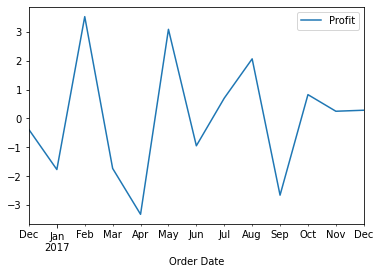

In [326]:
#PLOTTING THE DIFFERENCED DATA FOR TEST DATA
diff.plot()
plt.show()

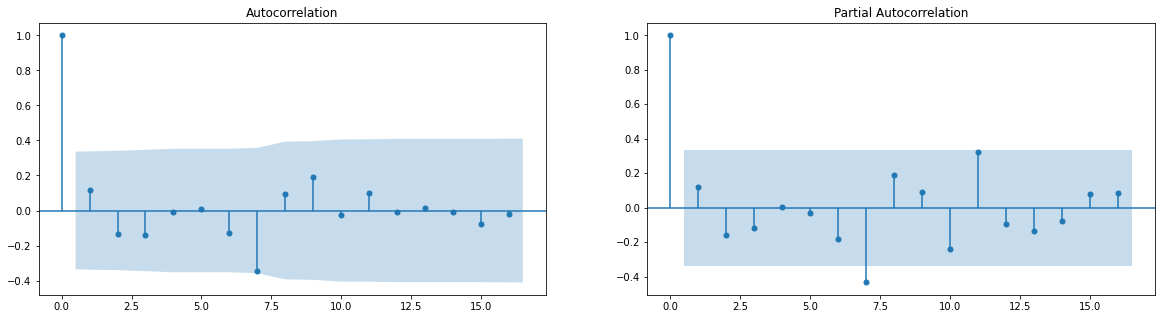

In [327]:
#plotting ACF and PACF plots
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(train_df1,ax=ax[0])
plot_pacf(train_df1,ax=ax[1])
plt.show()

#### SARIMA MODEL

In [328]:
#FINDING THE BEST P,Q,D VALUES
aic=[]
llf=[]
for p in range(0,3):
    for q in range(0,3):
        for d in range(0,2):
            print(p,d,q)
            m2 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
            aic.append(m2.aic)
            llf.append(m2.llf)
            m2.summary()
            print('AIC=',m2.aic,'LLR=',m2.llf)      

0 0 0
AIC= 242.39916277042437 LLR= -120.19958138521218
0 1 0
AIC= 96.2841918326156 LLR= -47.1420959163078
0 0 1
AIC= 198.11934377057983 LLR= -96.05967188528992
0 1 1
AIC= 90.78808130868413 LLR= -42.394040654342064
0 0 2
AIC= 174.0961989144177 LLR= -82.04809945720885
0 1 2
AIC= 94.78669335586955 LLR= -42.39334667793477
1 0 0
AIC= 138.5096655432042 LLR= -66.2548327716021
1 1 0
AIC= 93.46567058946077 LLR= -43.732835294730386
1 0 1
AIC= 127.61531668580557 LLR= -58.80765834290278
1 1 1
AIC= 94.78645001864469 LLR= -42.39322500932234
1 0 2
AIC= 127.62107058783755 LLR= -56.810535293918775
1 1 2
AIC= 98.57457502445857 LLR= -42.287287512229284
2 0 0
AIC= 132.84412940222785 LLR= -61.42206470111392
2 1 0
AIC= 96.69464029598593 LLR= -43.34732014799297
2 0 1
AIC= 127.31464935032353 LLR= -56.65732467516177
2 1 1
AIC= 98.52281311630927 LLR= -42.26140655815463
2 0 2
AIC= 131.34772935027007 LLR= -56.67386467513503
2 1 2
AIC= 102.29128980110767 LLR= -42.14564490055383


In [329]:
max(llf) #-->2,1,2

-42.14564490055383

In [330]:
min(aic) #-->0,1,1

90.78808130868413

Comparison of SARIMA Models:-
    
We choose p=2,d=1,q=2

In [331]:
#PUTTING P,D,Q VALUES
p,d,q=2,1,2
m2= sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Profit   No. Observations:                   34
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                 -42.146
Date:                            Tue, 24 May 2022   AIC                            102.291
Time:                                    22:19:51   BIC                            111.692
Sample:                                01-31-2014   HQIC                           104.331
                                     - 10-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8211      4.493     -0.183      0.855      -9.628       7.986
ar.L2          0.0775      0.666   

In [332]:
#PREDICTING THE VALUES
predictions = m2.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31     0.000000
2014-02-28     6.633660
2014-03-31     5.680361
2014-04-30     7.987861
2014-05-31     9.039450
2014-06-30     8.862780
2014-07-31     7.370559
2014-08-31     6.508552
2014-09-30    10.197534
2014-10-31     8.488887
2014-11-30     7.445237
2014-12-31     8.272083
2015-01-31    10.959546
2015-02-28     9.374019
2015-03-31    11.325128
Freq: M, Name: predicted_mean, dtype: float64


In [333]:
# actual vs predicted values
actual1 = []; pred1 = []

for i in range(len(test_df1)):
    actual1.append(test_df1.iloc[i][0])
    pred1.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual1, 'predicted':pred1})
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

       actual  predicted       err
0    9.226789   0.000000  9.226789
1    8.841204   6.633660  2.207544
2    7.072351   5.680361  1.391990
3   10.602329   7.987861  2.614468
4    8.871622   9.039450 -0.167829
5    5.550791   8.862780 -3.311989
6    8.641038   7.370559  1.270480
7    7.695008   6.508552  1.186456
8    8.400010  10.197534 -1.797524
9   10.466986   8.488887  1.978099
10   7.809894   7.445237  0.364658
11   8.637037   8.272083  0.364955
12   8.888345  10.959546 -2.071201
13   9.174993   9.374019 -0.199027


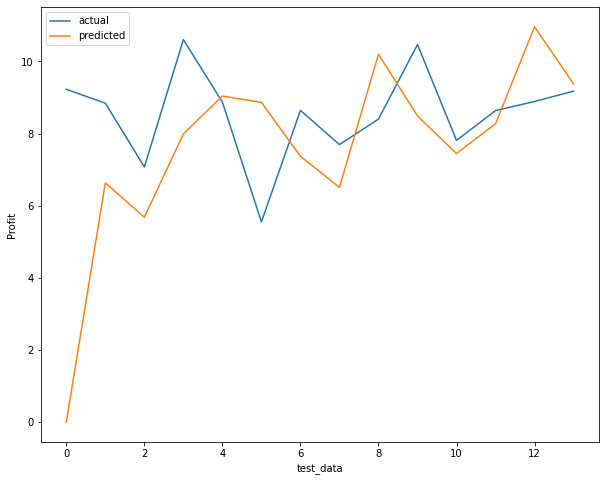

In [334]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res1.actual.plot(figsize=(10,8),legend=True)
plt.xlabel('test_data')
plt.ylabel('Profit')
df_res1.predicted.plot(legend=True)
plt.show()

In [335]:
mse2 = mean_squared_error(df_res1.actual,df_res1.predicted)
rmse2=np.sqrt(mse2)
rmse2,mse2

(2.982554252757617, 8.895629870642548)

In [336]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [337]:
fcast1=m2.forecast(len(test_df1))
fcast1

2016-11-30     9.033293
2016-12-31    10.118512
2017-01-31     9.087218
2017-02-28     7.361730
2017-03-31     8.928744
2017-04-30     9.945607
2017-05-31     6.498560
2017-06-30    11.844656
2017-07-31     7.045047
2017-08-31    10.464566
2017-09-30    10.167400
2017-10-31    11.043853
2017-11-30     9.218004
2017-12-31     9.513853
Freq: M, Name: predicted_mean, dtype: float64

In [338]:
mse22 = mean_squared_error(test_df1,fcast1)
rmse22=np.sqrt(mse22)
rmse22,mse22

(2.2482947689377433, 5.054829368032821)

In [339]:
#FORCASTING THE FUTURE DATA
fcast1 = m2.predict(start=len(df1_os_profit)-1, end=len(df1_os_profit)+len(test_df1), typ='levels').rename('Forecasted Profit')
print(fcast1)

2017-12-31     9.513853
2018-01-31     8.128836
2018-02-28     7.178550
2018-03-31     9.803360
2018-04-30    11.076306
2018-05-31     9.794845
2018-06-30    10.234962
2018-07-31     7.871121
2018-08-31    12.340205
2018-09-30    10.583722
2018-10-31     9.883528
2018-11-30     9.944781
2018-12-31     9.387126
2019-01-31    11.058442
2019-02-28     9.623282
2019-03-31     9.840864
Freq: M, Name: Forecasted Profit, dtype: float64


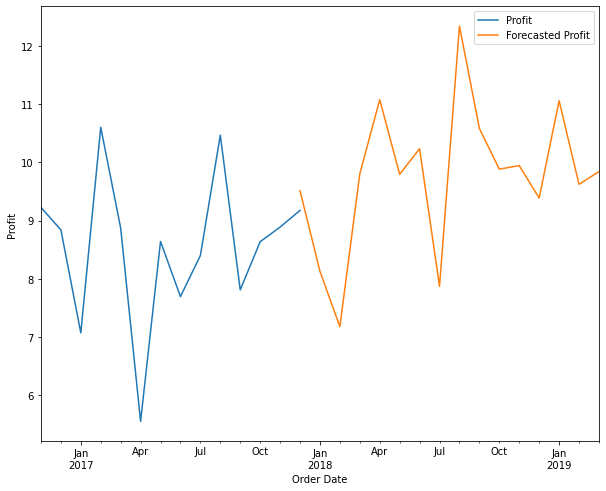

In [340]:
#VISUALIZING THE FORECASTED DATA
test_df1.plot(figsize=(10,8),legend=True)
plt.ylabel('Profit')
fcast1.plot(legend=True)
plt.show()

## CATEGORY - FURNITURE

In [341]:
#OUTLIER TREATMENT
Index=[]
def myoutliers(df,col):
    
    Q1=np.quantile(df[col],0.25)
    Q3=np.quantile(df[col],0.75)
    
    IQR=Q3-Q1
    
    global mylist
    global my_outlier_df
    
    UF=Q3+1.5*IQR
    LF=Q1-1.5*IQR
    
    print('LOWER RANGE OF',col,'IS',LF)
    print('UPPER RANGE OF',col,'IS',UF)
    
    mylist=[x for x in df[col] if((x<LF) | (x>UF))]
    print('TOTAL OUTLIERS IN',col,'ARE',len(mylist))
    my_outlier_df=df.loc[df[col].isin(mylist)]
    
    Index.append(my_outlier_df.index)
    

In [342]:
myoutliers(df_f,'Sales')
Index[0]

LOWER RANGE OF Sales IS -535.152
UPPER RANGE OF Sales IS 1017.3600000000001
TOTAL OUTLIERS IN Sales ARE 164


Int64Index([   0,   11,   23,   38,   41,   42,   46,   54,   59,   69,
            ...
            2008, 2011, 2012, 2014, 2024, 2048, 2060, 2084, 2091, 2114],
           dtype='int64', length=164)

In [343]:
myoutliers(df_f,'Profit')
Index[1]

LOWER RANGE OF Profit IS -82.7124000000004
UPPER RANGE OF Profit IS 103.59000000000024
TOTAL OUTLIERS IN Profit ARE 407


Int64Index([   0,    8,   11,   27,   32,   38,   40,   41,   42,   54,
            ...
            2069, 2073, 2084, 2085, 2089, 2091, 2094, 2101, 2105, 2114],
           dtype='int64', length=407)

In [344]:
#f category sales 
df_f_sales1=df_f.drop(Index[0]).reset_index()
df_f_sales1.drop(['index'],axis=1,inplace=True)
df_f_sales=df_f_sales1[['Sales']]
df_f_sales.index=df_f_sales1['Order Date']
df_f_sales.tail(2)

,Sales
Order Date,
2017-12-29,101.120
2017-12-30,323.136


In [345]:
#f category profit
df_f_profit1=df_f.drop(Index[1]).reset_index()
df_f_profit1.drop(['index'],axis=1,inplace=True)
df_f_profit=df_f_profit1[['Profit']]
df_f_profit.index=df_f_profit1['Order Date']
df_f_profit.tail(2)

,Profit
Order Date,
2017-12-29,37.4144
2017-12-30,12.1176


### SALES

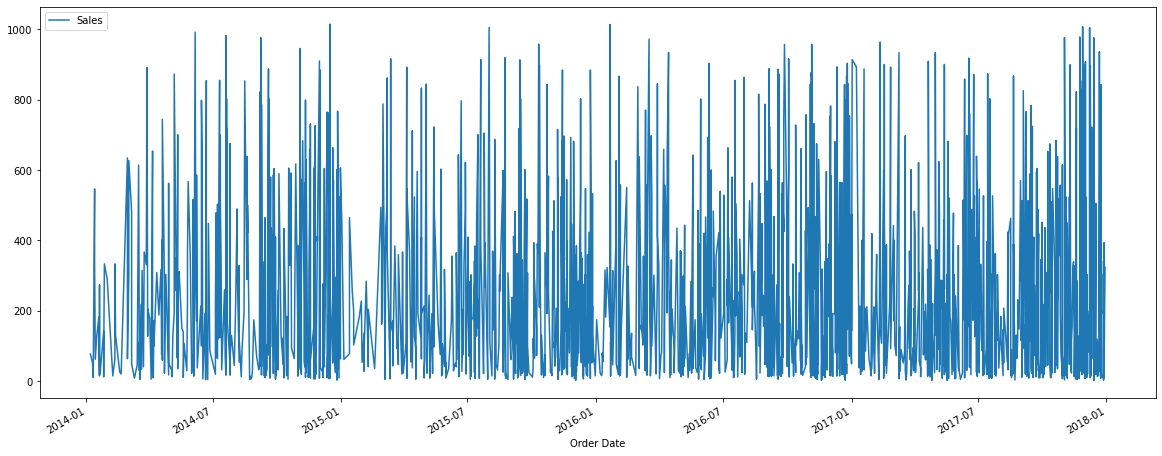

In [346]:
#VISUAL INSPECTION OF DATA
df_f_sales.plot(figsize=(20,8))
plt.show()

In [347]:
#AS THE DATA IS LARGE, WE ARE SAMPLING THE DATA FOR 7 DAYS
df1_f_sales=df_f_sales.resample('M').mean()
print(df1_f_sales.shape)
df1_f_sales.head(2)

(48, 1)


,Sales
Order Date,
2014-01-31,144.486944
2014-02-28,97.239667


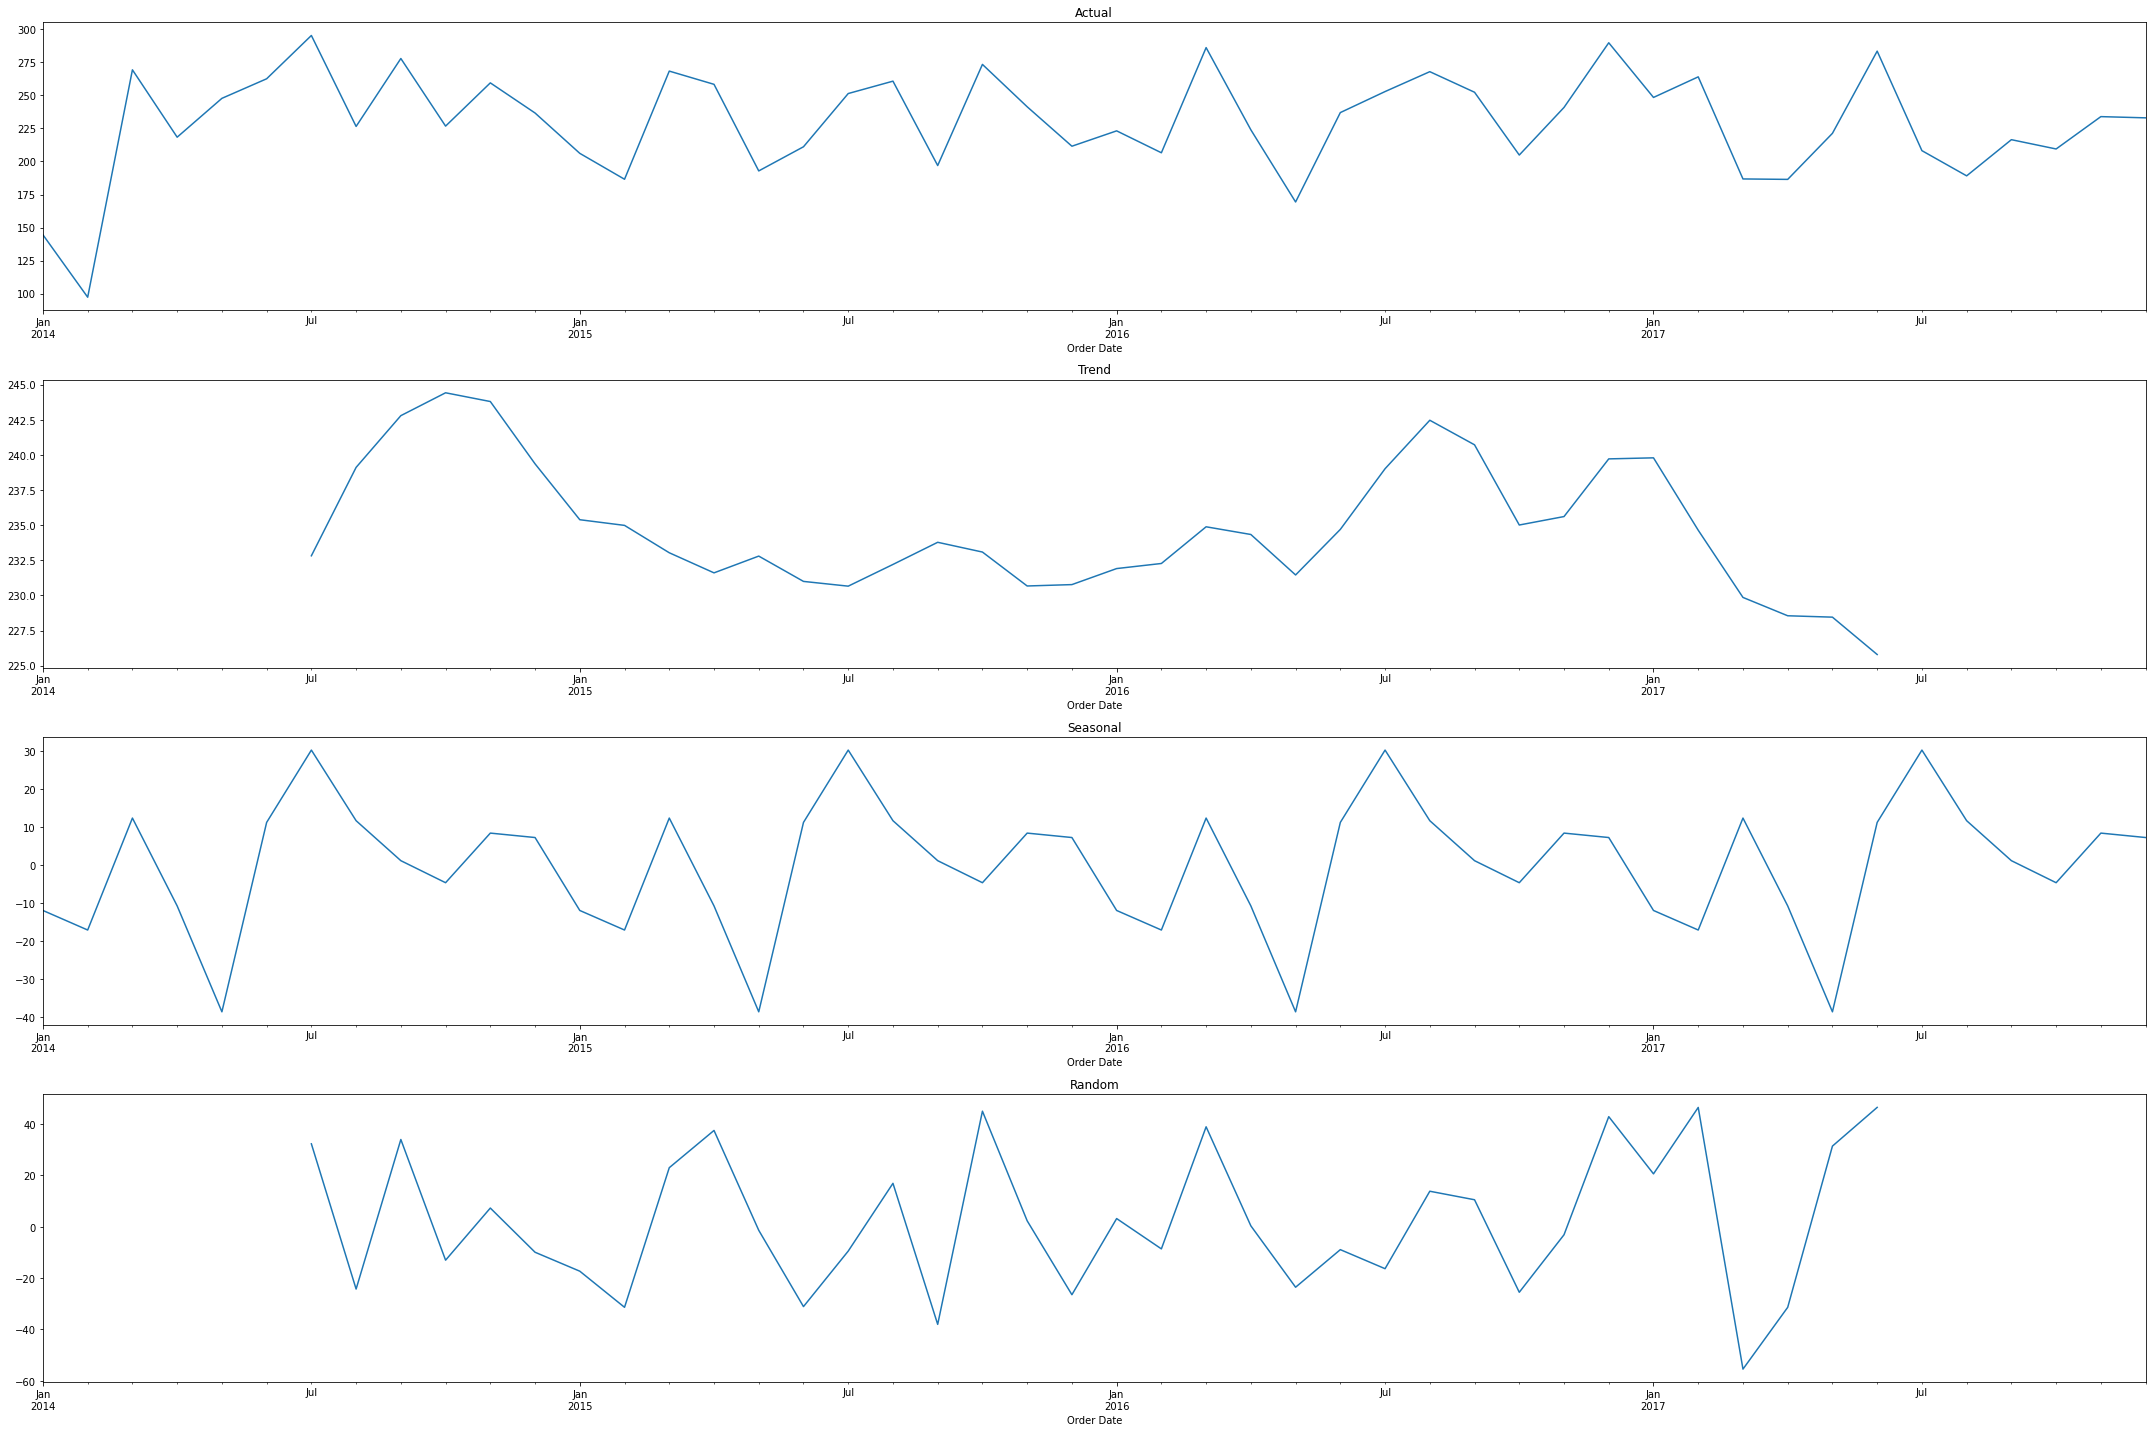

In [348]:
#DECOMPOSITION OF DATA
fig,ax = plt.subplots(4,1,figsize=(30,20))

result = seasonal_decompose(df1_f_sales, period=12)

result.observed.plot(ax=ax[0])
ax[0].set_title("Actual")

result.trend.plot(ax=ax[1])
ax[1].set_title("Trend")

result.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonal")

result.resid.plot(ax=ax[3])
ax[3].set_title("Random")

fig.tight_layout()

plt.show()

There is decreasing trend and seasonality in the data.

##### SPLITTING DATASET INTO 70 % TRAIN AND 30 % TEST

In [349]:
split= int(round(0.7 * len(df1_f_sales),0))
train_df1=df1_f_sales.iloc[:split]
test_df1=df1_f_sales.iloc[split:]
print(train_df1.shape,test_df1.shape)
train_df1.head(2),test_df1.head(2)

(34, 1) (14, 1)


(                 Sales
 Order Date            
 2014-01-31  144.486944
 2014-02-28   97.239667,
                  Sales
 Order Date            
 2016-11-30  240.941227
 2016-12-31  289.898840)

#### CHECKING FOR STATIONARITY

In [350]:
# Augmented dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [351]:
#TRAINING
r=checkStationarity(train_df1)
print('TRAINING:\n',r)

#TESTING
r=checkStationarity(test_df1)
print(r)
# difference in the data 
diff = test_df1 - test_df1.shift()
print(diff)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff))
diff.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff))
print(diff)
# checking again the differenced data for stationarity
checkStationarity(diff)

TRAINING:
 p-value=2.361956610002018e-09. Data is stationary
p-value=0.6333591567841534. Data is not stationary
                Sales
Order Date           
2016-11-30        NaN
2016-12-31  48.957613
2017-01-31 -41.397507
2017-02-28  15.588567
2017-03-31 -77.299249
2017-04-30  -0.334649
2017-05-31  34.867362
2017-06-30  62.239417
2017-07-31 -75.349898
2017-08-31 -19.080711
2017-09-30  27.386552
2017-10-31  -7.037019
2017-11-30  24.495284
2017-12-31  -0.921851
Before removing Nulls,total records =  14
After removing Nulls, total records =  13
                Sales
Order Date           
2016-12-31  48.957613
2017-01-31 -41.397507
2017-02-28  15.588567
2017-03-31 -77.299249
2017-04-30  -0.334649
2017-05-31  34.867362
2017-06-30  62.239417
2017-07-31 -75.349898
2017-08-31 -19.080711
2017-09-30  27.386552
2017-10-31  -7.037019
2017-11-30  24.495284
2017-12-31  -0.921851


'p-value=0.04484610463348077. Data is stationary'

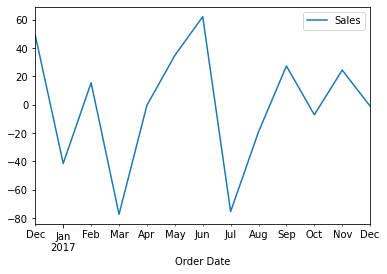

In [352]:
#PLOTTING THE DIFFERENCED DATA FOR TEST DATA
diff.plot()
plt.show()

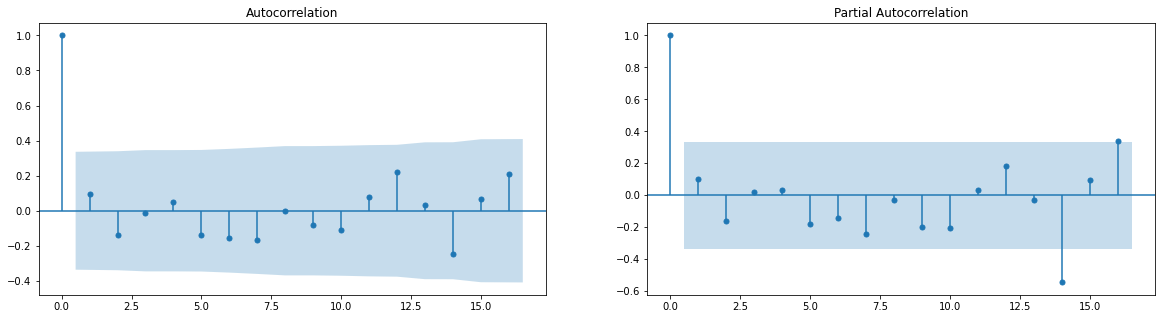

In [353]:
#plotting ACF and PACF plots
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(train_df1,ax=ax[0])
plot_pacf(train_df1,ax=ax[1])
plt.show()

#### SARIMA MODEL

In [354]:
#FINDING THE BEST P,Q,D VALUES
aic=[]
llf=[]
for p in range(0,3):
    for q in range(0,3):
        for d in range(0,2):
            print(p,d,q)
            m1 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
            aic.append(m1.aic)
            llf.append(m1.llf)
            m1.summary()
            print('AIC=',m1.aic,'LLR=',m1.llf)      

0 0 0
AIC= 469.57439017639064 LLR= -233.78719508819532
0 1 0
AIC= 236.04979759525227 LLR= -117.02489879762614
0 0 1
AIC= 425.8252946022278 LLR= -209.9126473011139
0 1 1
AIC= 228.2444775829396 LLR= -111.1222387914698
0 0 2
AIC= 404.12772168648036 LLR= -197.06386084324018
0 1 2
AIC= 232.19318344026792 LLR= -111.09659172013396
1 0 0
AIC= 373.15388246196534 LLR= -183.57694123098267
1 1 0
AIC= 227.95073901349755 LLR= -110.97536950674878
1 0 1
AIC= 363.0303641676012 LLR= -176.5151820838006
1 1 1
AIC= 231.7350450730327 LLR= -110.86752253651635
1 0 2
AIC= 366.51747815853975 LLR= -176.25873907926987
1 1 2
AIC= 235.4285768747111 LLR= -110.71428843735555
2 0 0
AIC= 365.9715224148238 LLR= -177.9857612074119
2 1 0
AIC= 231.71263151338601 LLR= -110.85631575669301
2 0 1
AIC= 366.3476180293754 LLR= -176.1738090146877
2 1 1
AIC= 234.78010249208083 LLR= -110.39005124604041
2 0 2
AIC= 370.7882788824107 LLR= -176.39413944120534
2 1 2
AIC= 238.79442817112232 LLR= -110.39721408556116


In [355]:
max(llf) #-->2,1,1

-110.39005124604041

In [356]:
min(aic) #-->1,1,1

227.95073901349755

Comparison of SARIMA Models:-
    
We choose p=2,d=0,q=1

In [357]:
#PUTTING P,D,Q VALUES
p,d,q=2,0,1
m1 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   34
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 12)   Log Likelihood                -176.174
Date:                            Tue, 24 May 2022   AIC                            366.348
Time:                                    22:20:04   BIC                            377.032
Sample:                                01-31-2014   HQIC                           369.991
                                     - 10-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1451      0.254      4.506      0.000       0.647       1.643
ar.L2         -0.1458      0.226   

In [358]:
#PREDICTING THE VALUES
predictions = m1.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31      0.000000
2014-02-28    140.175885
2014-03-31    115.310686
2014-04-30    185.934067
2014-05-31    185.899650
2014-06-30    201.708700
2014-07-31    213.438640
2014-08-31    229.371715
2014-09-30    218.961278
2014-10-31    232.719787
2014-11-30    224.111190
2014-12-31    228.028485
2015-01-31    197.861817
2015-02-28    179.688368
2015-03-31    246.527715
Freq: M, Name: predicted_mean, dtype: float64


In [359]:
# actual vs predicted values
actual1 = []; pred1 = []

for i in range(len(test_df1)):
    actual1.append(test_df1.iloc[i][0])
    pred1.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual1, 'predicted':pred1})
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

        actual   predicted         err
0   240.941227    0.000000  240.941227
1   289.898840  140.175885  149.722955
2   248.501333  115.310686  133.190647
3   264.089900  185.934067   78.155833
4   186.790651  185.899650    0.891001
5   186.456002  201.708700  -15.252698
6   221.323364  213.438640    7.884724
7   283.562781  229.371715   54.191066
8   208.212882  218.961278  -10.748395
9   189.132171  232.719787  -43.587615
10  216.518724  224.111190   -7.592466
11  209.481704  228.028485  -18.546781
12  233.976989  197.861817   36.115172
13  233.055138  179.688368   53.366770


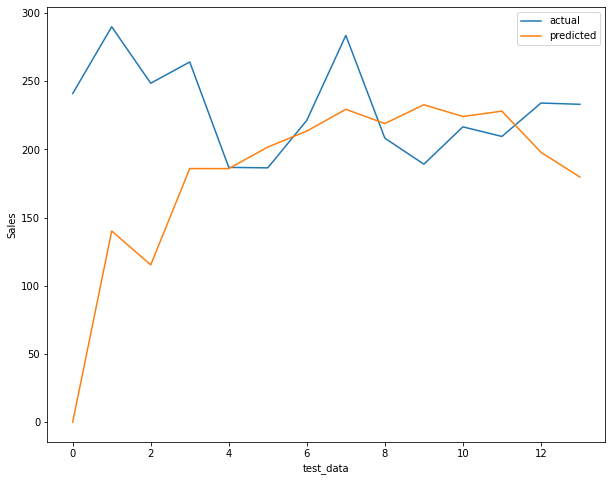

In [360]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res1.actual.plot(figsize=(10,8),legend=True)
plt.xlabel('test_data')
plt.ylabel('Sales')
df_res1.predicted.plot(legend=True)
plt.show()

In [361]:
mse1 = mean_squared_error(df_res1.actual,df_res1.predicted)
rmse1=np.sqrt(mse1)
rmse1,mse1

(90.28500695394042, 8151.38248067307)

In [362]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [363]:
fcast1=m1.forecast(len(test_df1))
fcast1

2016-11-30    235.277456
2016-12-31    223.376798
2017-01-31    206.012712
2017-02-28    188.549460
2017-03-31    259.059544
2017-04-30    232.019418
2017-05-31    212.107797
2017-06-30    234.620130
2017-07-31    253.189734
2017-08-31    244.406119
2017-09-30    238.474830
2017-10-31    232.232197
2017-11-30    239.360462
2017-12-31    224.317624
Freq: M, Name: predicted_mean, dtype: float64

In [364]:
mse11 = mean_squared_error(test_df1,fcast1)
rmse11=np.sqrt(mse11)
rmse11,mse11

(44.666331731596, 1995.08119035698)

In [365]:
#FORCASTING THE FUTURE DATA
fcast1 = m1.predict(start=len(df1_f_sales)-1, end=len(df1_f_sales)+len(test_df1), typ='levels').rename('Forecasted Sales')
print(fcast1)

2017-12-31    224.317624
2018-01-31    205.726465
2018-02-28    188.195894
2018-03-31    258.335653
2018-04-30    232.230272
2018-05-31    213.230201
2018-06-30    234.561867
2018-07-31    253.164083
2018-08-31    243.795170
2018-09-30    238.117628
2018-10-31    232.927295
2018-11-30    239.455722
2018-12-31    224.360879
2019-01-31    205.772490
2019-02-28    188.271983
2019-03-31    258.273612
Freq: M, Name: Forecasted Sales, dtype: float64


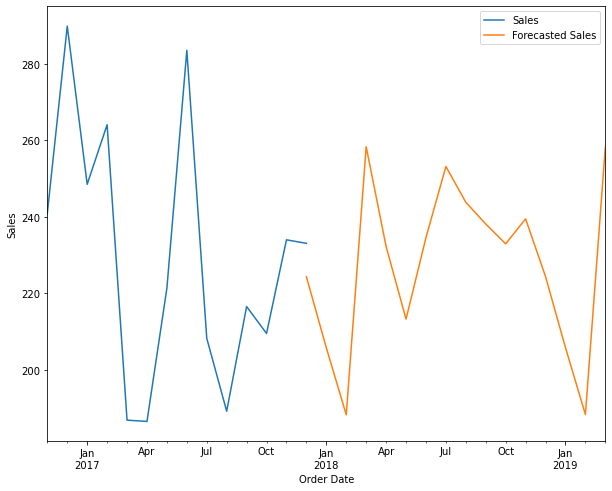

In [366]:
#VISUALIZING THE FORECASTED DATA
test_df1.plot(figsize=(10,8),legend=True)
plt.ylabel('Sales')
fcast1.plot(legend=True)
plt.show()

### PROFIT

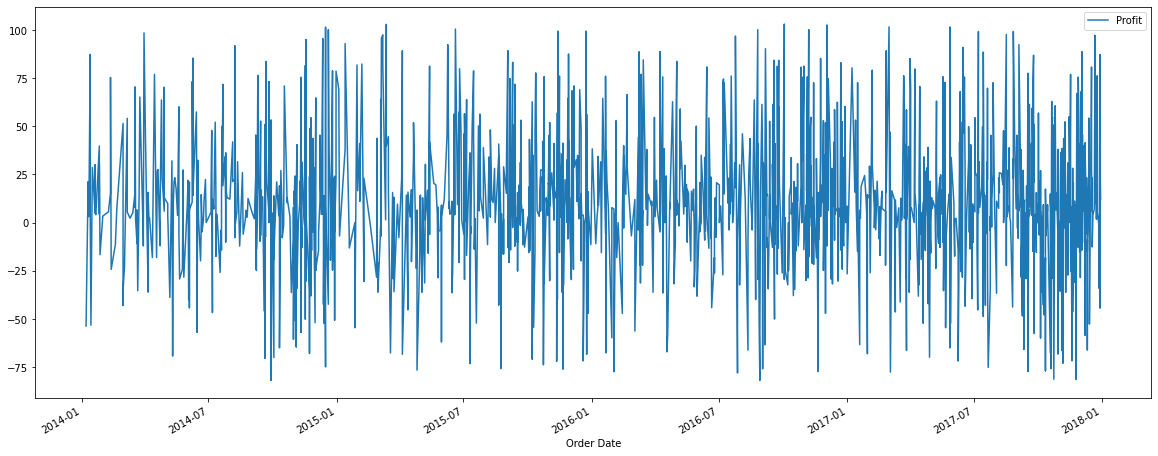

In [367]:
#VISUAL INSPECTION OF DATA
df_f_profit.plot(figsize=(20,8))
plt.show()

In [368]:
#AS THE DATA IS LARGE, WE ARE SAMPLING THE DATA FOR 7 DAYS
df1_f_profit=df_f_profit.resample('M').mean()
print(df1_f_profit.shape)
df1_f_profit.head(2)

(48, 1)


,Profit
Order Date,
2014-01-31,9.140488
2014-02-28,17.241671


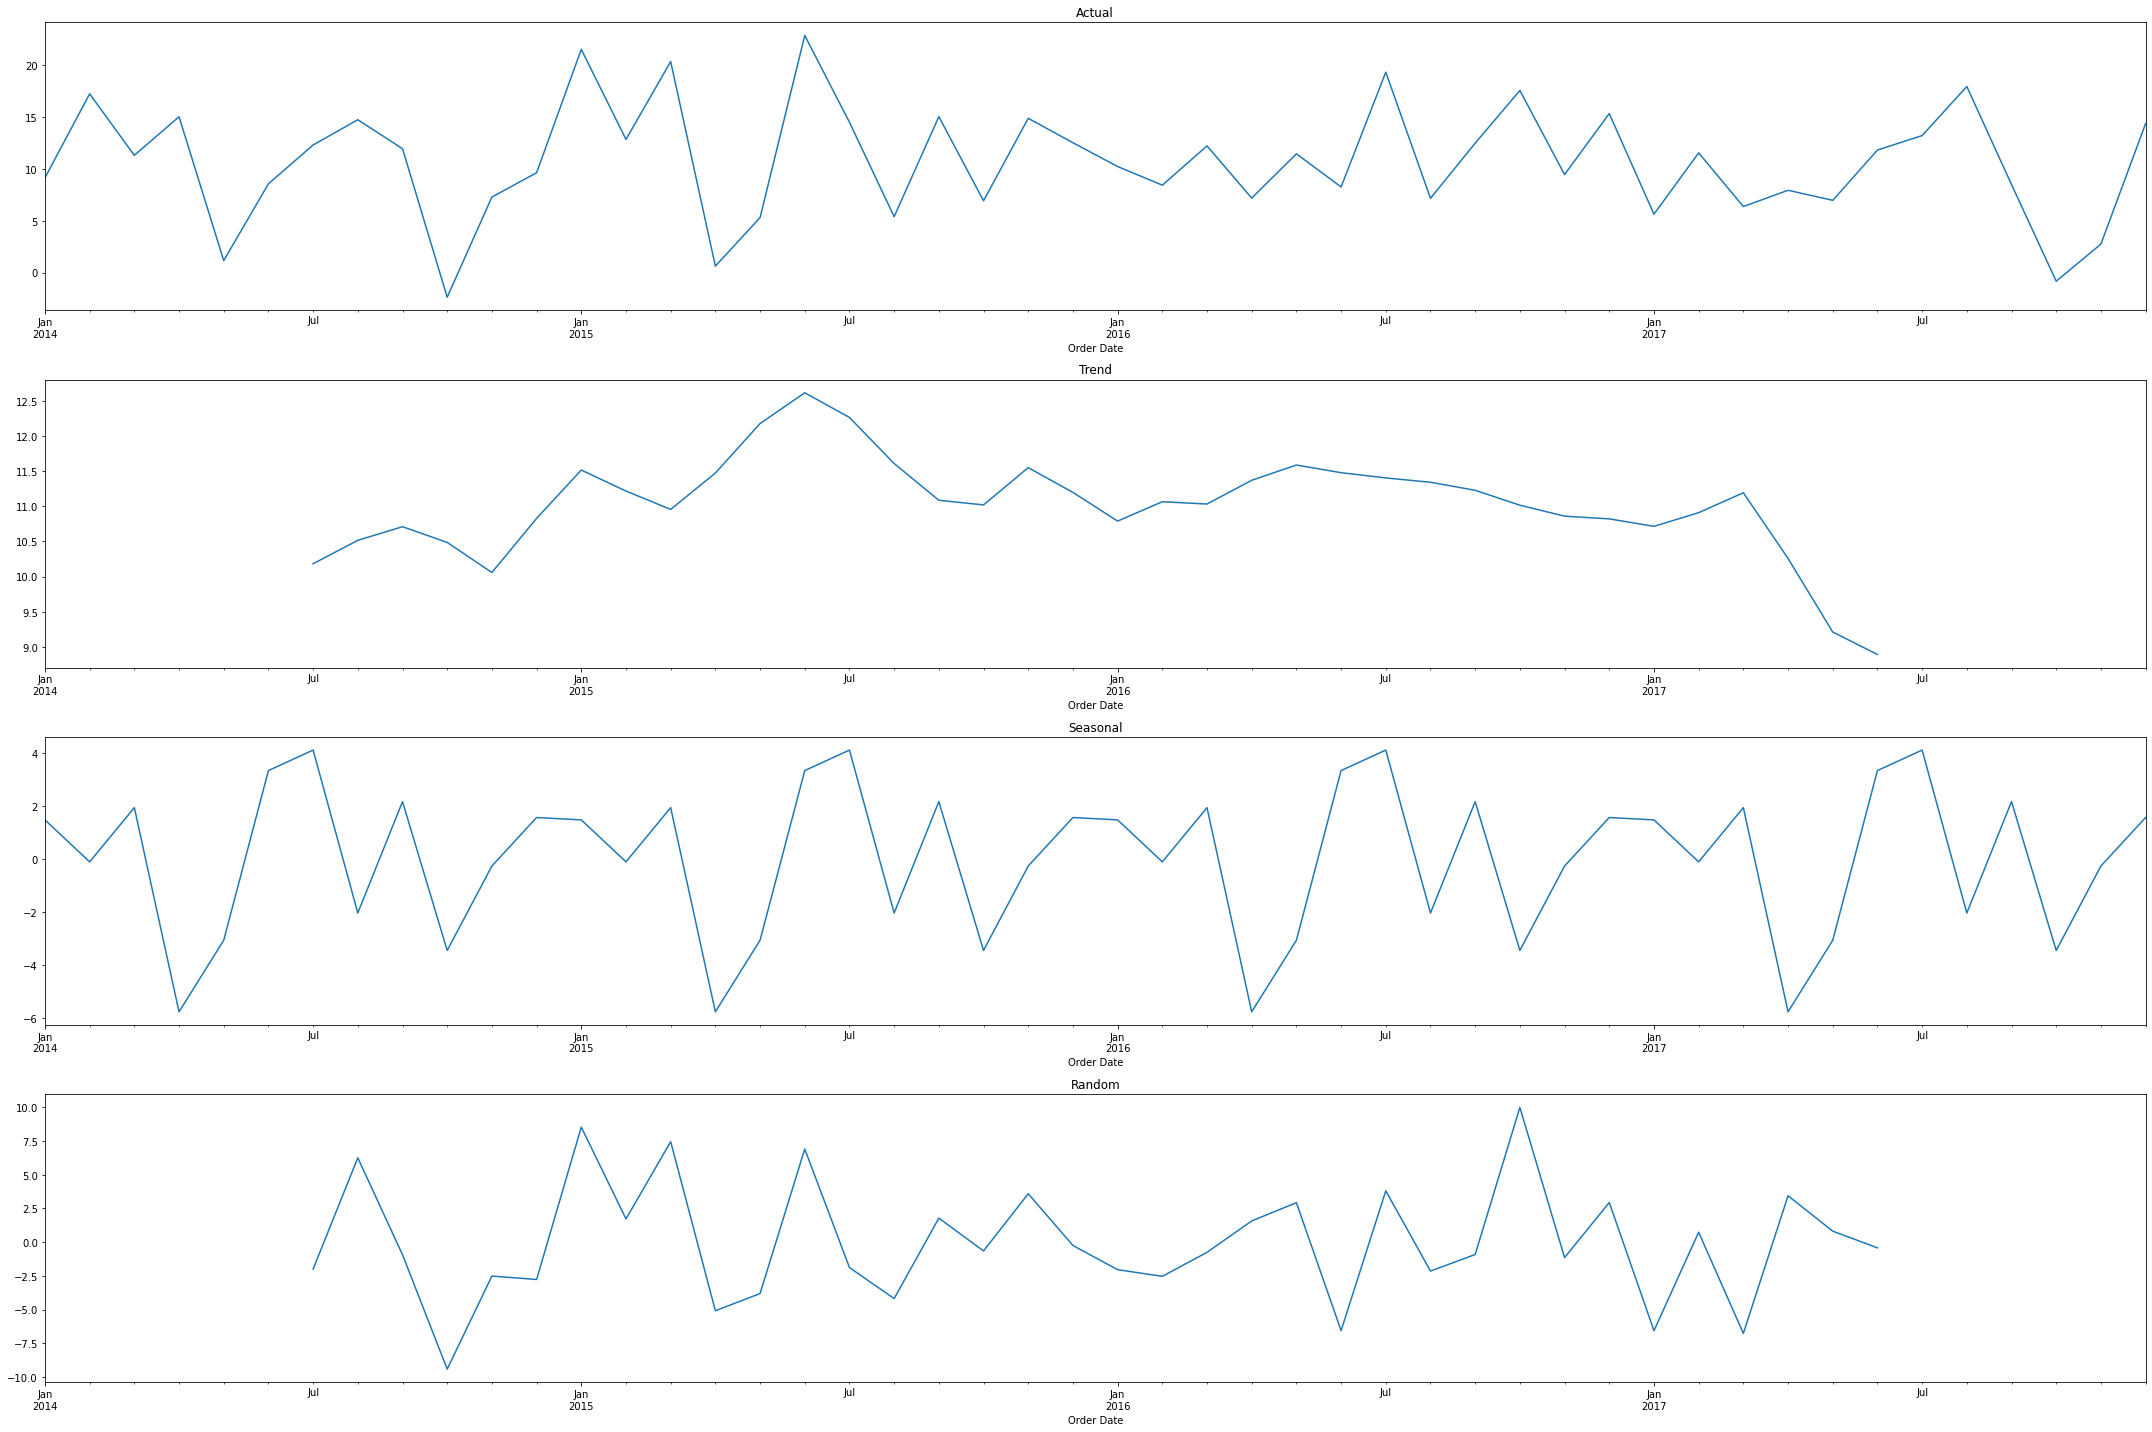

In [369]:
#DECOMPOSITION OF DATA
fig,ax = plt.subplots(4,1,figsize=(30,20))

result = seasonal_decompose(df1_f_profit, period=12)

result.observed.plot(ax=ax[0])
ax[0].set_title("Actual")

result.trend.plot(ax=ax[1])
ax[1].set_title("Trend")

result.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonal")

result.resid.plot(ax=ax[3])
ax[3].set_title("Random")

fig.tight_layout()

plt.show()

There is decreasing trend and seasonality in data.

##### SPLITTING DATASET INTO 70 % TRAIN AND 30 % TEST

In [370]:
split= int(round(0.7 * len(df1_f_profit),0))
train_df1=df1_f_profit.iloc[:split]
test_df1=df1_f_profit.iloc[split:]
print(train_df1.shape,test_df1.shape)
train_df1.head(2),test_df1.head(2)

(34, 1) (14, 1)


(               Profit
 Order Date           
 2014-01-31   9.140488
 2014-02-28  17.241671,
                Profit
 Order Date           
 2016-11-30   9.457336
 2016-12-31  15.338744)

#### CHECKING FOR STATIONARITY

In [371]:
# Augmented dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [372]:
#TRAINING
r=checkStationarity(train_df1)
print('TRAINING:\n',r)

#TESTING
r=checkStationarity(test_df1)
print(r)
# difference in the data 
diff = test_df1 - test_df1.shift()
print(diff)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff))
diff.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff))
print(diff)
# checking again the differenced data for stationarity
checkStationarity(diff)

TRAINING:
 p-value=3.4538645990247715e-08. Data is stationary
p-value=6.590381059893198e-05. Data is stationary
               Profit
Order Date           
2016-11-30        NaN
2016-12-31   5.881408
2017-01-31  -9.704567
2017-02-28   5.913665
2017-03-31  -5.174744
2017-04-30   1.567176
2017-05-31  -0.968878
2017-06-30   4.849066
2017-07-31   1.397323
2017-08-31   4.732197
2017-09-30  -9.456133
2017-10-31  -9.322353
2017-11-30   3.578217
2017-12-31  11.618957
Before removing Nulls,total records =  14
After removing Nulls, total records =  13
               Profit
Order Date           
2016-12-31   5.881408
2017-01-31  -9.704567
2017-02-28   5.913665
2017-03-31  -5.174744
2017-04-30   1.567176
2017-05-31  -0.968878
2017-06-30   4.849066
2017-07-31   1.397323
2017-08-31   4.732197
2017-09-30  -9.456133
2017-10-31  -9.322353
2017-11-30   3.578217
2017-12-31  11.618957


'p-value=0.00085339662218021. Data is stationary'

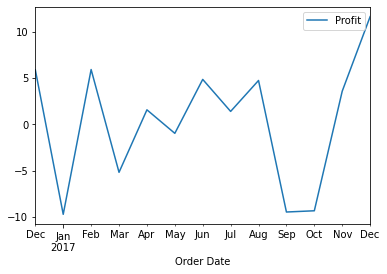

In [373]:
#PLOTTING THE DIFFERENCED DATA FOR TEST DATA
diff.plot()
plt.show()

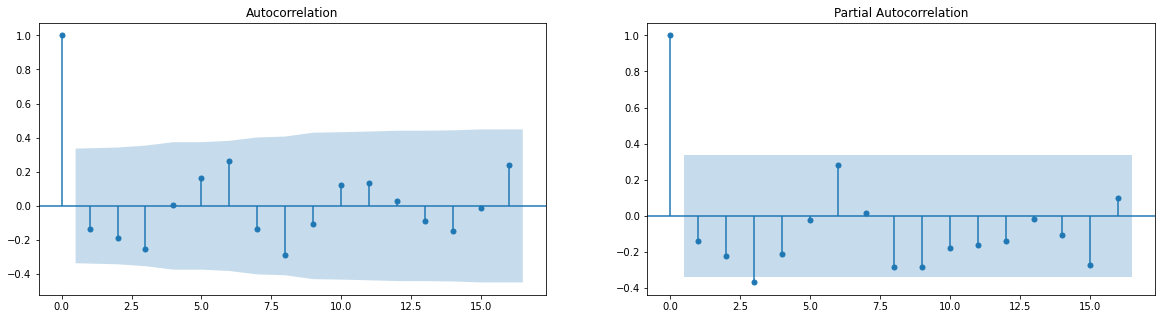

In [374]:
#plotting ACF and PACF plots
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(train_df1,ax=ax[0])
plot_pacf(train_df1,ax=ax[1])
plt.show()

#### SARIMA MODEL

In [375]:
#FINDING THE BEST P,Q,D VALUES
aic=[]
llf=[]
for p in range(0,3):
    for q in range(0,3):
        for d in range(0,2):
            print(p,d,q)
            m2 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
            aic.append(m2.aic)
            llf.append(m2.llf)
            m2.summary()
            print('AIC=',m2.aic,'LLR=',m2.llf)      

0 0 0
AIC= 270.951043660332 LLR= -134.475521830166
0 1 0
AIC= 168.71466013138522 LLR= -83.35733006569261
0 0 1
AIC= 252.52374895652326 LLR= -123.26187447826163
0 1 1
AIC= 156.68581639553156 LLR= -75.34290819776578
0 0 2
AIC= 251.73107839528262 LLR= -120.86553919764131
0 1 2
AIC= 159.91494269872246 LLR= -74.95747134936123
1 0 0
AIC= 245.17620443124508 LLR= -119.58810221562254
1 1 0
AIC= 164.08727568847607 LLR= -79.04363784423803
1 0 1
AIC= 230.1707973543315 LLR= -110.08539867716576
1 1 1
AIC= 160.26747621815647 LLR= -75.13373810907824
1 0 2
AIC= 232.03391633289573 LLR= -109.01695816644786
1 1 2
AIC= 162.9065974045739 LLR= -74.45329870228694
2 0 0
AIC= 243.53022628646218 LLR= -116.76511314323109
2 1 0
AIC= 166.02105613296519 LLR= -78.01052806648259
2 0 1
AIC= 232.35679719111448 LLR= -109.17839859555724
2 1 1
AIC= 163.56382000852327 LLR= -74.78191000426163
2 0 2
AIC= 236.66885051612599 LLR= -109.33442525806299
2 1 2
AIC= 167.06988198192153 LLR= -74.53494099096076


In [376]:
max(llf) #-->1,1,2

-74.45329870228694

In [377]:
min(aic) #-->0,1,1

156.68581639553156

Comparison of SARIMA Models:-
    
We choose p=1,d=1,q=2

In [378]:
#PUTTING P,D,Q VALUES
p,d,q=1,1,2
m2= sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Profit   No. Observations:                   34
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 -74.453
Date:                            Tue, 24 May 2022   AIC                            162.907
Time:                                    22:20:14   BIC                            170.218
Sample:                                01-31-2014   HQIC                           164.493
                                     - 10-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6828      3.779      0.181      0.857      -6.724       8.089
ma.L1         -1.9792    308.246   

In [379]:
#PREDICTING THE VALUES
predictions = m2.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31     0.000000
2014-02-28     9.140094
2014-03-31    17.240978
2014-04-30    11.311723
2014-05-31    15.035426
2014-06-30     1.158619
2014-07-31     8.565265
2014-08-31    12.308035
2014-09-30    14.743640
2014-10-31    11.950181
2014-11-30    -2.370943
2014-12-31     7.287407
2015-01-31    14.203957
2015-02-28    29.633733
2015-03-31    15.757941
Freq: M, Name: predicted_mean, dtype: float64


In [380]:
# actual vs predicted values
actual1 = []; pred1 = []

for i in range(len(test_df1)):
    actual1.append(test_df1.iloc[i][0])
    pred1.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual1, 'predicted':pred1})
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

       actual  predicted        err
0    9.457336   0.000000   9.457336
1   15.338744   9.140094   6.198650
2    5.634176  17.240978 -11.606802
3   11.547841  11.311723   0.236118
4    6.373097  15.035426  -8.662328
5    7.940273   1.158619   6.781654
6    6.971395   8.565265  -1.593870
7   11.820462  12.308035  -0.487574
8   13.217784  14.743640  -1.525856
9   17.949981  11.950181   5.999800
10   8.493848  -2.370943  10.864791
11  -0.828505   7.287407  -8.115912
12   2.749712  14.203957 -11.454244
13  14.368669  29.633733 -15.265064


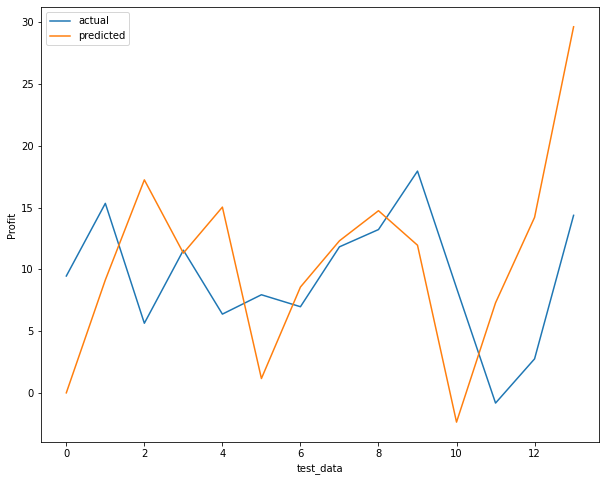

In [381]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res1.actual.plot(figsize=(10,8),legend=True)
plt.xlabel('test_data')
plt.ylabel('Profit')
df_res1.predicted.plot(legend=True)
plt.show()

In [382]:
mse2 = mean_squared_error(df_res1.actual,df_res1.predicted)
rmse2=np.sqrt(mse2)
rmse2,mse2

(8.336247921928567, 69.49302941585837)

In [383]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [384]:
fcast1=m2.forecast(len(test_df1))
fcast1

2016-11-30    10.966673
2016-12-31    11.375997
2017-01-31    13.892846
2017-02-28    13.670223
2017-03-31    15.290357
2017-04-30     9.017998
2017-05-31     7.125352
2017-06-30    13.868178
2017-07-31    16.613693
2017-08-31    10.494554
2017-09-30    14.295990
2017-10-31     8.697263
2017-11-30    12.162201
2017-12-31    12.481953
Freq: M, Name: predicted_mean, dtype: float64

In [385]:
mse22 = mean_squared_error(test_df1,fcast1)
rmse22=np.sqrt(mse22)
rmse22,mse22

(5.727519960003769, 32.804484892241575)

In [386]:
#FORCASTING THE FUTURE DATA
fcast1 = m2.predict(start=len(df1_f_profit)-1, end=len(df1_f_profit)+len(test_df1), typ='levels').rename('Forecasted Profit')
print(fcast1)

2017-12-31    12.481953
2018-01-31    15.513638
2018-02-28    14.599660
2018-03-31    16.541881
2018-04-30     9.276304
2018-05-31     7.772846
2018-06-30    15.297768
2018-07-31    17.211403
2018-08-31    10.908258
2018-09-30    15.103712
2018-10-31     9.273460
2018-11-30    13.108717
2018-12-31    13.251001
2019-01-31    15.628229
2019-02-28    15.232917
2019-03-31    16.794037
Freq: M, Name: Forecasted Profit, dtype: float64


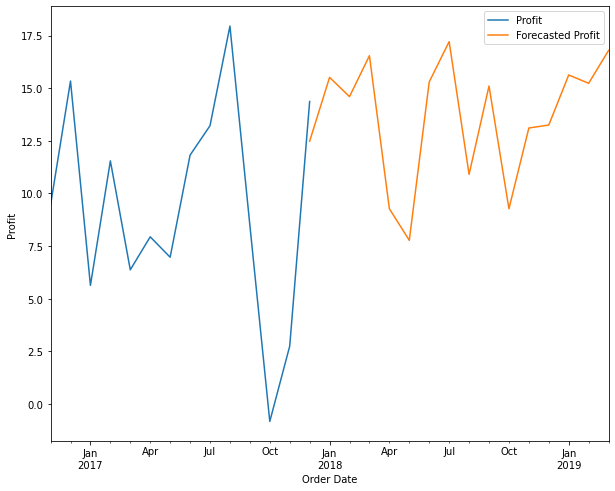

In [387]:
#VISUALIZING THE FORECASTED DATA
test_df1.plot(figsize=(10,8),legend=True)
plt.ylabel('Profit')
fcast1.plot(legend=True)
plt.show()

## CATEGORY - TECHNOLOGY

In [388]:
#OUTLIER TREATMENT
Index=[]
def myoutliers(df,col):
    
    Q1=np.quantile(df[col],0.25)
    Q3=np.quantile(df[col],0.75)
    
    IQR=Q3-Q1
    
    global mylist
    global my_outlier_df
    
    UF=Q3+1.5*IQR
    LF=Q1-1.5*IQR
    
    print('LOWER RANGE OF',col,'IS',LF)
    print('UPPER RANGE OF',col,'IS',UF)
    
    mylist=[x for x in df[col] if((x<LF) | (x>UF))]
    print('TOTAL OUTLIERS IN',col,'ARE',len(mylist))
    my_outlier_df=df.loc[df[col].isin(mylist)]
    
    Index.append(my_outlier_df.index)
    

In [389]:
myoutliers(df_t,'Sales')
Index[0]

LOWER RANGE OF Sales IS -502.761
UPPER RANGE OF Sales IS 1019.3110000000001
TOTAL OUTLIERS IN Sales ARE 172


Int64Index([  27,   28,   31,   39,   56,   62,   66,   70,   84,  104,
            ...
            1740, 1746, 1747, 1760, 1767, 1784, 1799, 1806, 1820, 1838],
           dtype='int64', length=172)

In [390]:
myoutliers(df_t,'Profit')
Index[1]

LOWER RANGE OF Profit IS -99.33277500000001
UPPER RANGE OF Profit IS 179.431025
TOTAL OUTLIERS IN Profit ARE 250


Int64Index([   1,    3,    6,    9,   27,   28,   31,   39,   52,   66,
            ...
            1767, 1779, 1784, 1790, 1799, 1806, 1811, 1820, 1837, 1838],
           dtype='int64', length=250)

In [391]:
#t category sales 
df_t_sales1=df_t.drop(Index[0]).reset_index()
df_t_sales1.drop(['index'],axis=1,inplace=True)
df_t_sales=df_t_sales1[['Sales']]
df_t_sales.index=df_t_sales1['Order Date']
df_t_sales.tail(2)

,Sales
Order Date,
2017-12-29,302.376
2017-12-30,90.930


In [392]:
#t category profit
df_t_profit1=df_t.drop(Index[1]).reset_index()
df_t_profit1.drop(['index'],axis=1,inplace=True)
df_t_profit=df_t_profit1[['Profit']]
df_t_profit.index=df_t_profit1['Order Date']
df_t_profit.tail(2)

,Profit
Order Date,
2017-12-29,22.6782
2017-12-30,2.7279


### SALES

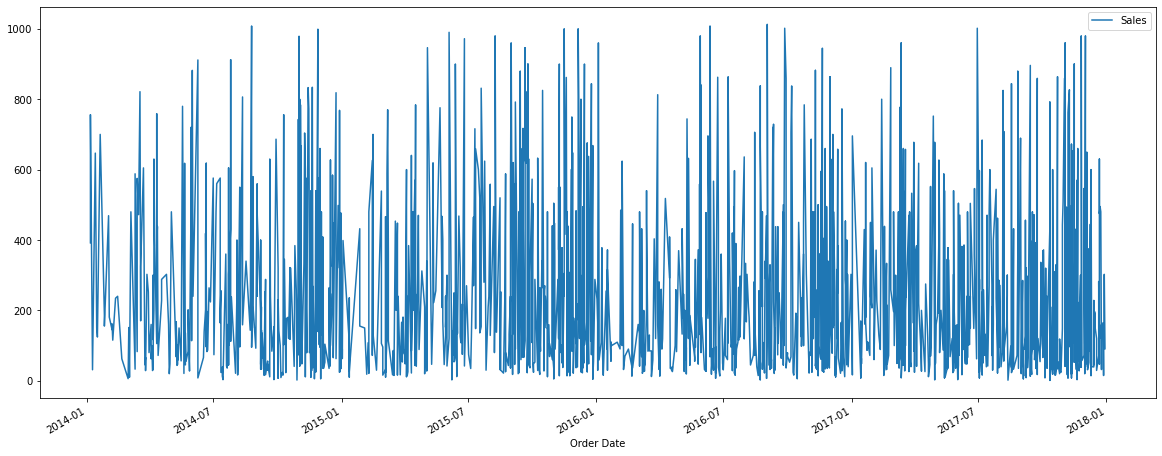

In [393]:
#VISUAL INSPECTION OF DATA
df_t_sales.plot(figsize=(20,8))
plt.show()

In [394]:
#AS THE DATA IS LARGE, WE ARE SAMPLING THE DATA FOR 7 DAYS
df1_t_sales=df_t_sales.resample('M').mean()
print(df1_t_sales.shape)
df1_t_sales.head(2)

(48, 1)


,Sales
Order Date,
2014-01-31,349.254444
2014-02-28,201.063750


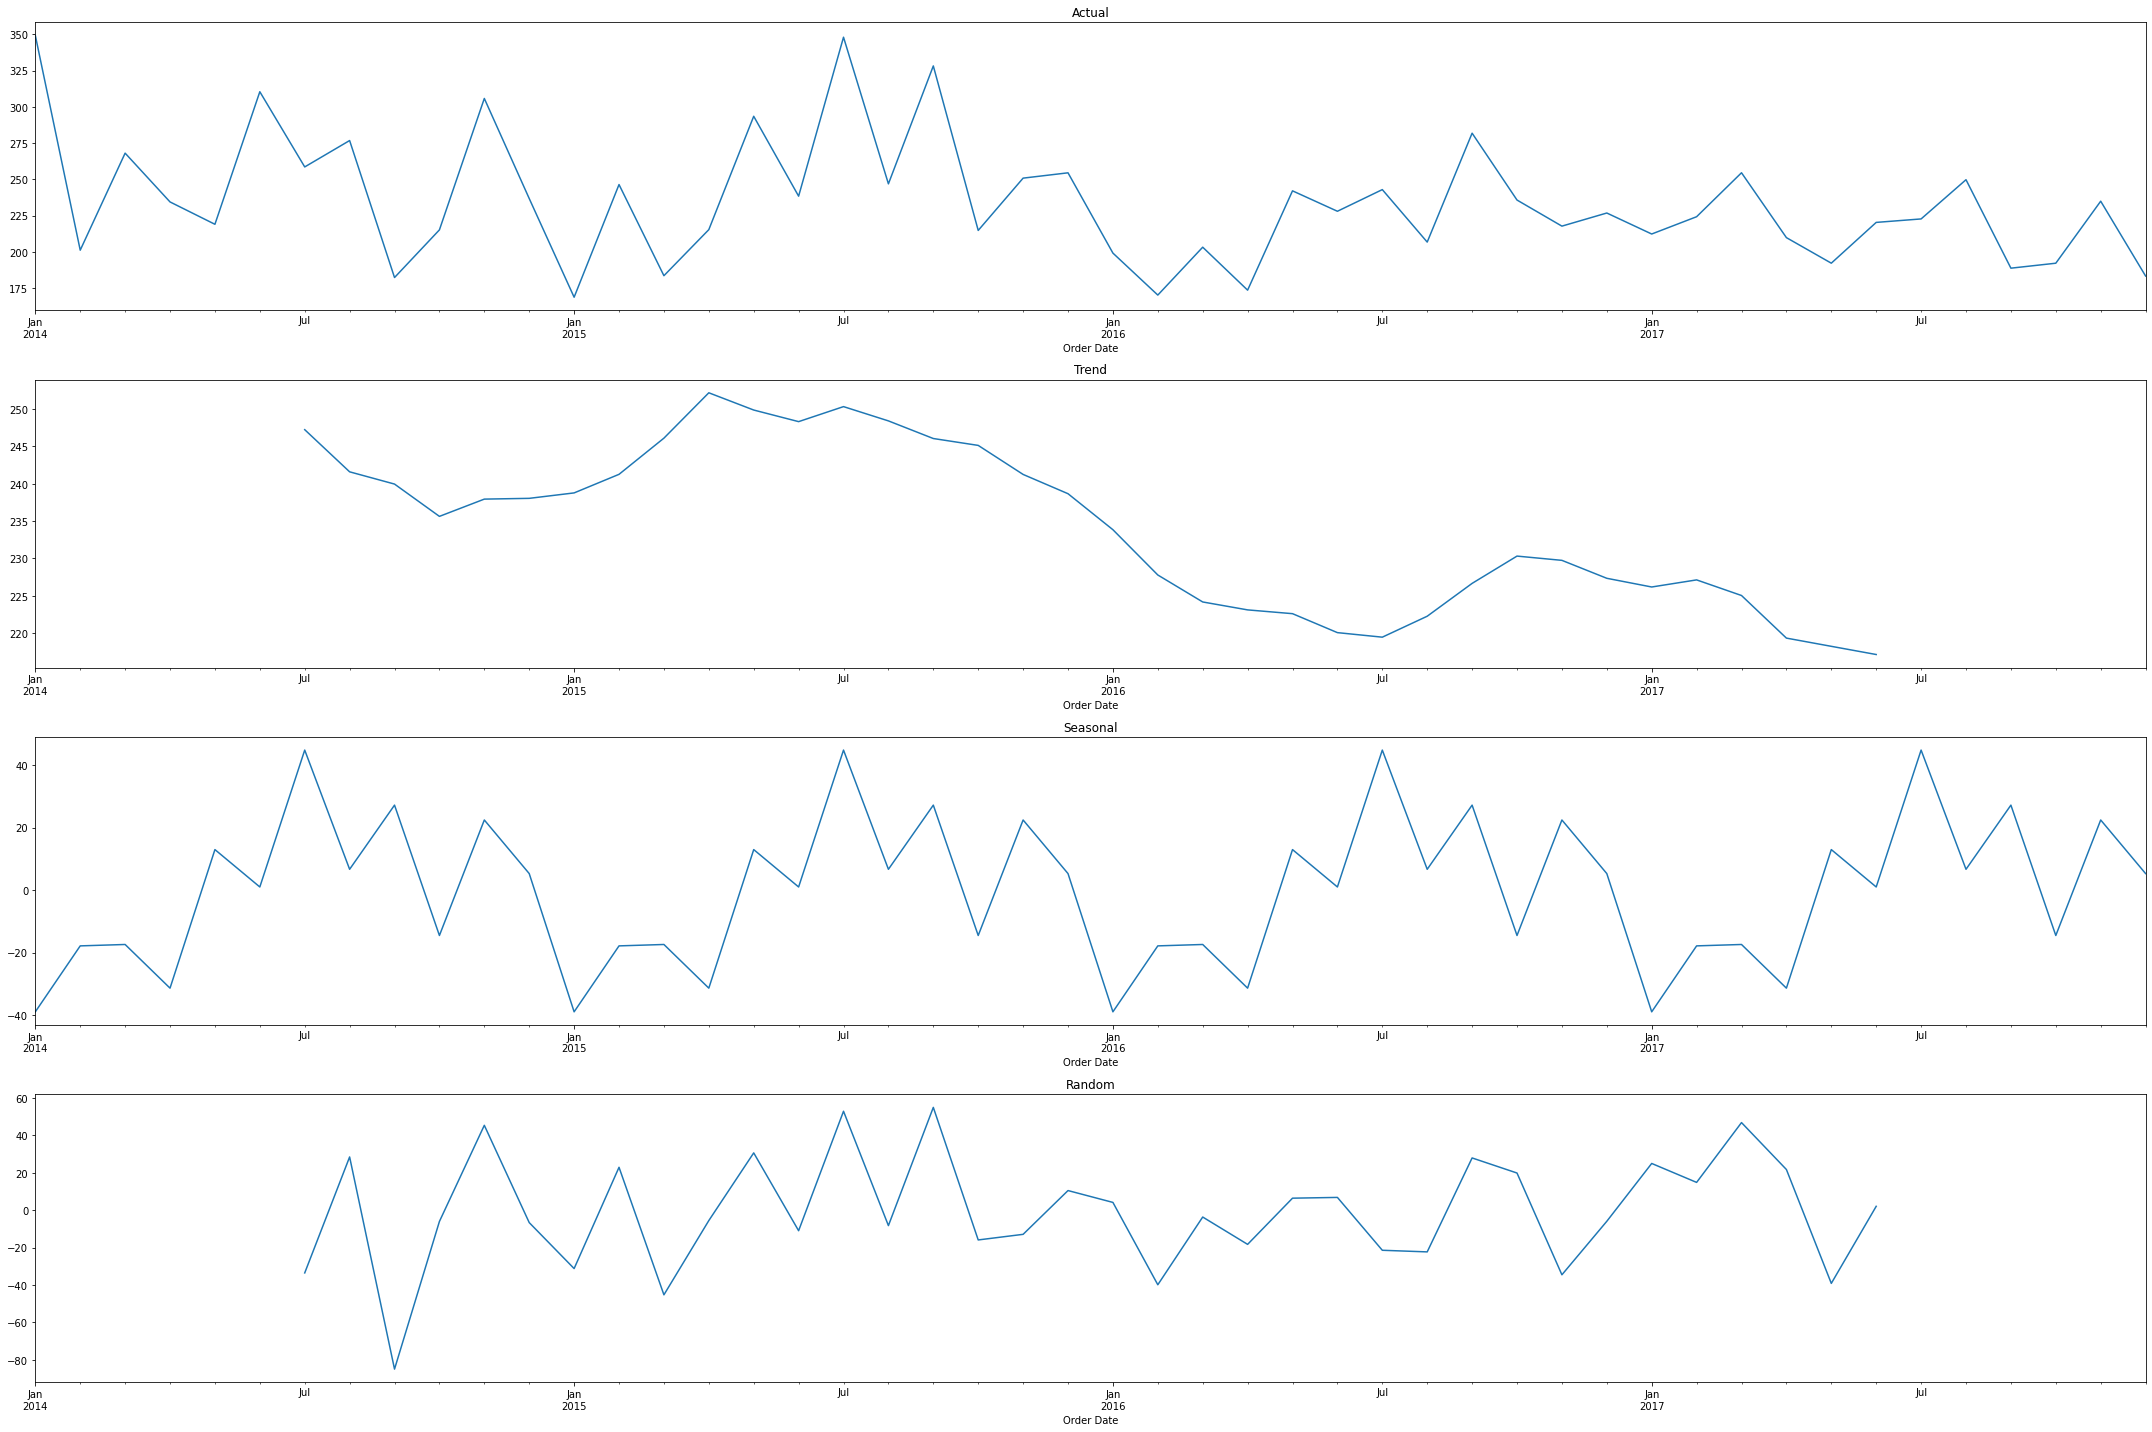

In [395]:
#DECOMPOSITION OF DATA
fig,ax = plt.subplots(4,1,figsize=(30,20))

result = seasonal_decompose(df1_t_sales, period=12)

result.observed.plot(ax=ax[0])
ax[0].set_title("Actual")

result.trend.plot(ax=ax[1])
ax[1].set_title("Trend")

result.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonal")

result.resid.plot(ax=ax[3])
ax[3].set_title("Random")

fig.tight_layout()

plt.show()

There is decresing trend and seasonality in the data.

##### SPLITTING DATASET INTO 70 % TRAIN AND 30 % TEST

In [396]:
split= int(round(0.7 * len(df1_t_sales),0))
train_df1=df1_t_sales.iloc[:split]
test_df1=df1_t_sales.iloc[split:]
print(train_df1.shape,test_df1.shape)
train_df1.head(2),test_df1.head(2)

(34, 1) (14, 1)


(                 Sales
 Order Date            
 2014-01-31  349.254444
 2014-02-28  201.063750,
                  Sales
 Order Date            
 2016-11-30  217.664382
 2016-12-31  226.717164)

#### CHECKING FOR STATIONARITY

In [397]:
# Augmented dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [398]:
#TRAINING
r=checkStationarity(train_df1)
print('TRAINING:\n',r)

#TESTING
r=checkStationarity(test_df1)
print(r)
# difference in the data 
diff = test_df1 - test_df1.shift()
print(diff)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff))
diff.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff))
print(diff)
# checking again the differenced data for stationarity
checkStationarity(diff)

TRAINING:
 p-value=0.031904532231584. Data is stationary
p-value=0.9424299649093639. Data is not stationary
                Sales
Order Date           
2016-11-30        NaN
2016-12-31   9.052781
2017-01-31 -14.494090
2017-02-28  11.930450
2017-03-31  30.342790
2017-04-30 -44.770564
2017-05-31 -17.636300
2017-06-30  28.147477
2017-07-31   2.393024
2017-08-31  27.071533
2017-09-30 -61.057424
2017-10-31   3.422901
2017-11-30  42.804051
2017-12-31 -51.655840
Before removing Nulls,total records =  14
After removing Nulls, total records =  13
                Sales
Order Date           
2016-12-31   9.052781
2017-01-31 -14.494090
2017-02-28  11.930450
2017-03-31  30.342790
2017-04-30 -44.770564
2017-05-31 -17.636300
2017-06-30  28.147477
2017-07-31   2.393024
2017-08-31  27.071533
2017-09-30 -61.057424
2017-10-31   3.422901
2017-11-30  42.804051
2017-12-31 -51.655840


'p-value=5.98283732455054e-06. Data is stationary'

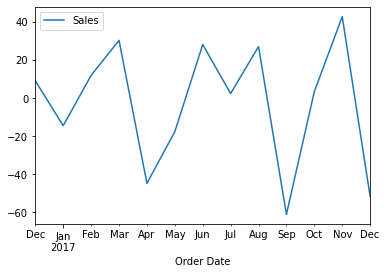

In [399]:
#PLOTTING THE DIFFERENCED DATA FOR TEST DATA
diff.plot()
plt.show()

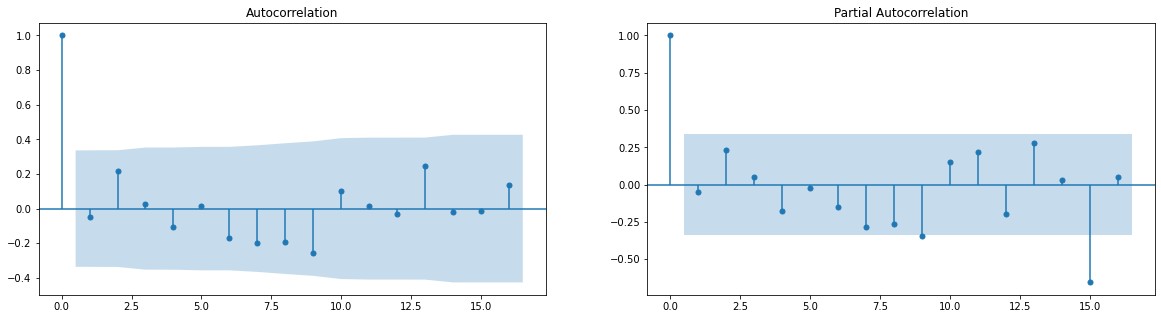

In [400]:
#plotting ACF and PACF plots
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(train_df1,ax=ax[0])
plot_pacf(train_df1,ax=ax[1])
plt.show()

#### SARIMA MODEL

In [401]:
#FINDING THE BEST P,Q,D VALUES
aic=[]
llf=[]
for p in range(0,3):
    for q in range(0,3):
        for d in range(0,2):
            print(p,d,q)
            m1 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
            aic.append(m1.aic)
            llf.append(m1.llf)
            m1.summary()
            print('AIC=',m1.aic,'LLR=',m1.llf)      

0 0 0
AIC= 473.0321869160929 LLR= -235.51609345804644
0 1 0
AIC= 258.4773101657611 LLR= -128.23865508288054
0 0 1
AIC= 436.3849641215341 LLR= -215.19248206076705
0 1 1
AIC= 244.35722317266718 LLR= -119.17861158633359
0 0 2
AIC= 419.4227796719075 LLR= -204.71138983595375
0 1 2
AIC= 244.43105889007524 LLR= -117.21552944503762
1 0 0
AIC= 390.75245619059746 LLR= -192.37622809529873
1 1 0
AIC= 244.41308328029479 LLR= -119.20654164014739
1 0 1
AIC= 376.9814875812551 LLR= -183.49074379062756
1 1 1
AIC= 245.3553114789621 LLR= -117.67765573948105
1 0 2
AIC= 380.9986299421251 LLR= -183.49931497106255
1 1 2
AIC= 247.76000658850475 LLR= -116.88000329425238
2 0 0
AIC= 380.021469974108 LLR= -185.010734987054
2 1 0
AIC= 244.30640583964632 LLR= -117.15320291982316
2 0 1
AIC= 380.08808806677166 LLR= -183.04404403338583
2 1 1
AIC= 248.26775992546536 LLR= -117.13387996273268
2 0 2
AIC= 383.28002261902793 LLR= -182.64001130951397
2 1 2
AIC= 250.75282261912747 LLR= -116.37641130956374


In [402]:
max(llf) #-->2,1,2

-116.37641130956374

In [403]:
min(aic) #-->2,1,1

244.30640583964632

Comparison of SARIMA Models:-
    
We choose p=2,d=0,q=0

In [404]:
#PUTTING P,D,Q VALUES
p,d,q=2,0,0
m1 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   34
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -185.011
Date:                            Tue, 24 May 2022   AIC                            380.021
Time:                                    22:20:27   BIC                            387.653
Sample:                                01-31-2014   HQIC                           382.624
                                     - 10-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3508      0.176      1.991      0.046       0.006       0.696
ar.L2          0.6406      0.183   

In [405]:
#PREDICTING THE VALUES
predictions = m1.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31      0.000000
2014-02-28    337.361465
2014-03-31    293.158919
2014-04-30    221.831717
2014-05-31    252.748801
2014-06-30    226.028064
2014-07-31    247.799355
2014-08-31    288.823232
2014-09-30    260.986310
2014-10-31    241.014372
2014-11-30    189.641363
2014-12-31    246.155856
2015-01-31    274.301887
2015-02-28    214.939636
2015-03-31    195.143936
Freq: M, Name: predicted_mean, dtype: float64


In [406]:
# actual vs predicted values
actual1 = []; pred1 = []

for i in range(len(test_df1)):
    actual1.append(test_df1.iloc[i][0])
    pred1.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual1, 'predicted':pred1})
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

        actual   predicted         err
0   217.664382    0.000000  217.664382
1   226.717164  337.361465 -110.644301
2   212.223074  293.158919  -80.935845
3   224.153524  221.831717    2.321807
4   254.496314  252.748801    1.747513
5   209.725750  226.028064  -16.302314
6   192.089450  247.799355  -55.709905
7   220.236927  288.823232  -68.586306
8   222.629951  260.986310  -38.356359
9   249.701484  241.014372    8.687112
10  188.644060  189.641363   -0.997303
11  192.066961  246.155856  -54.088896
12  234.871012  274.301887  -39.430875
13  183.215171  214.939636  -31.724464


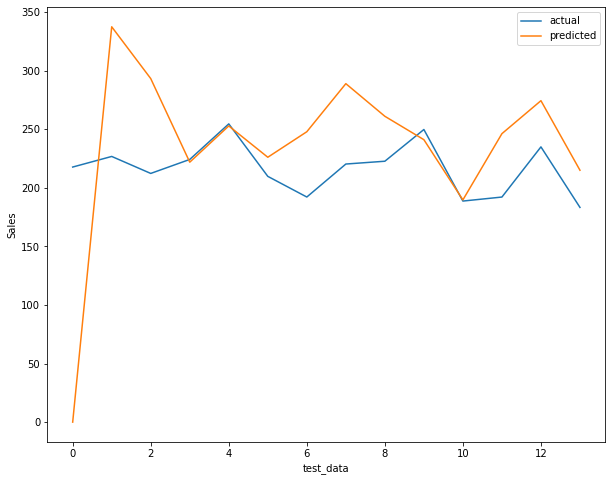

In [407]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res1.actual.plot(figsize=(10,8),legend=True)
plt.xlabel('test_data')
plt.ylabel('Sales')
df_res1.predicted.plot(legend=True)
plt.show()

In [408]:
mse1 = mean_squared_error(df_res1.actual,df_res1.predicted)
rmse1=np.sqrt(mse1)
rmse1,mse1

(76.1984981329437, 5806.211117716225)

In [409]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [410]:
fcast1=m1.forecast(len(test_df1))
fcast1

2016-11-30    249.537792
2016-12-31    237.715007
2017-01-31    262.368283
2017-02-28    243.613885
2017-03-31    254.005413
2017-04-30    246.622109
2017-05-31    231.519744
2017-06-30    237.377074
2017-07-31    220.238342
2017-08-31    234.980043
2017-09-30    217.192611
2017-10-31    234.717843
2017-11-30    227.350371
2017-12-31    226.086821
Freq: M, Name: predicted_mean, dtype: float64

In [411]:
mse11 = mean_squared_error(test_df1,fcast1)
rmse11=np.sqrt(mse11)
rmse11,mse11

(29.266419105399553, 856.5232872528959)

In [412]:
#FORCASTING THE FUTURE DATA
fcast1 = m1.predict(start=len(df1_t_sales)-1, end=len(df1_t_sales)+len(test_df1), typ='levels').rename('Forecasted Sales')
print(fcast1)

2017-12-31    226.086821
2018-01-31    230.849767
2018-02-28    234.757331
2018-03-31    227.959258
2018-04-30    231.220531
2018-05-31    221.150210
2018-06-30    221.323891
2018-07-31    218.987542
2018-08-31    221.700947
2018-09-30    210.898636
2018-10-31    214.841478
2018-11-30    212.012013
2018-12-31    212.403731
2019-01-31    207.227607
2019-02-28    208.259246
2019-03-31    205.909798
Freq: M, Name: Forecasted Sales, dtype: float64


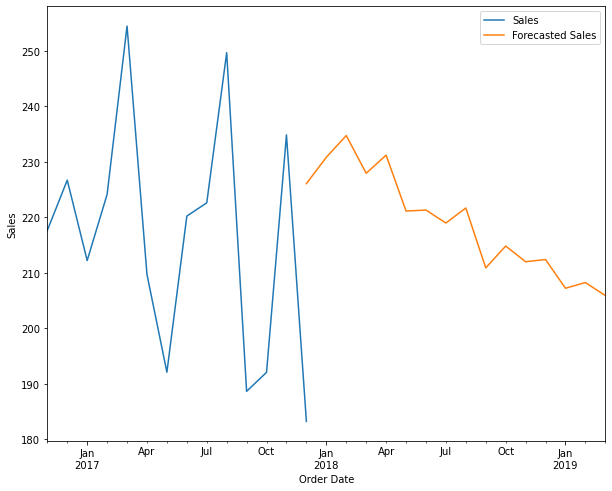

In [413]:
#VISUALIZING THE FORECASTED DATA
test_df1.plot(figsize=(10,8),legend=True)
plt.ylabel('Sales')
fcast1.plot(legend=True)
plt.show()

### PROFIT

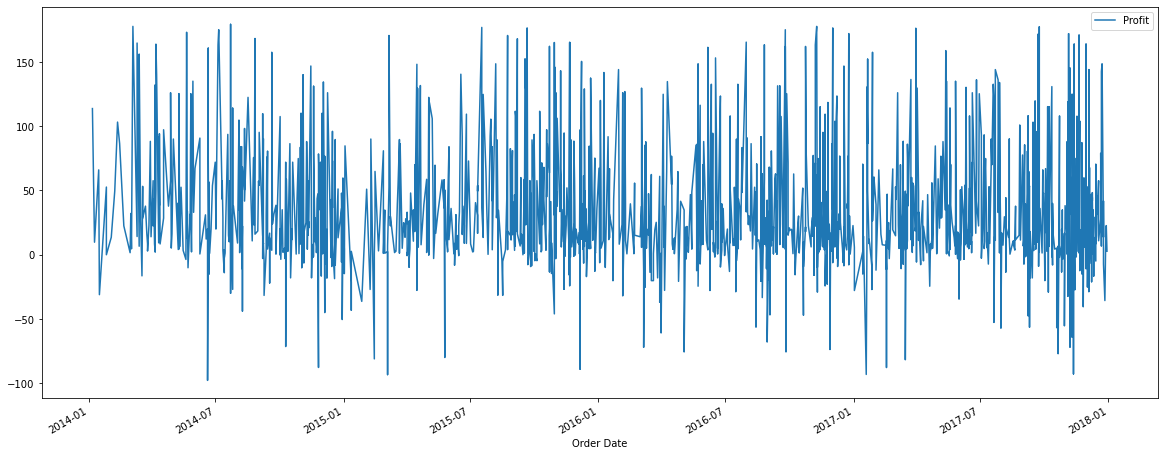

In [414]:
#VISUAL INSPECTION OF DATA
df_t_profit.plot(figsize=(20,8))
plt.show()

In [415]:
#AS THE DATA IS LARGE, WE ARE SAMPLING THE DATA FOR 7 DAYS
df1_t_profit=df_t_profit.resample('M').mean()
print(df1_t_profit.shape)
df1_t_profit.head(2)

(48, 1)


,Profit
Order Date,
2014-01-31,35.164433
2014-02-28,51.315671


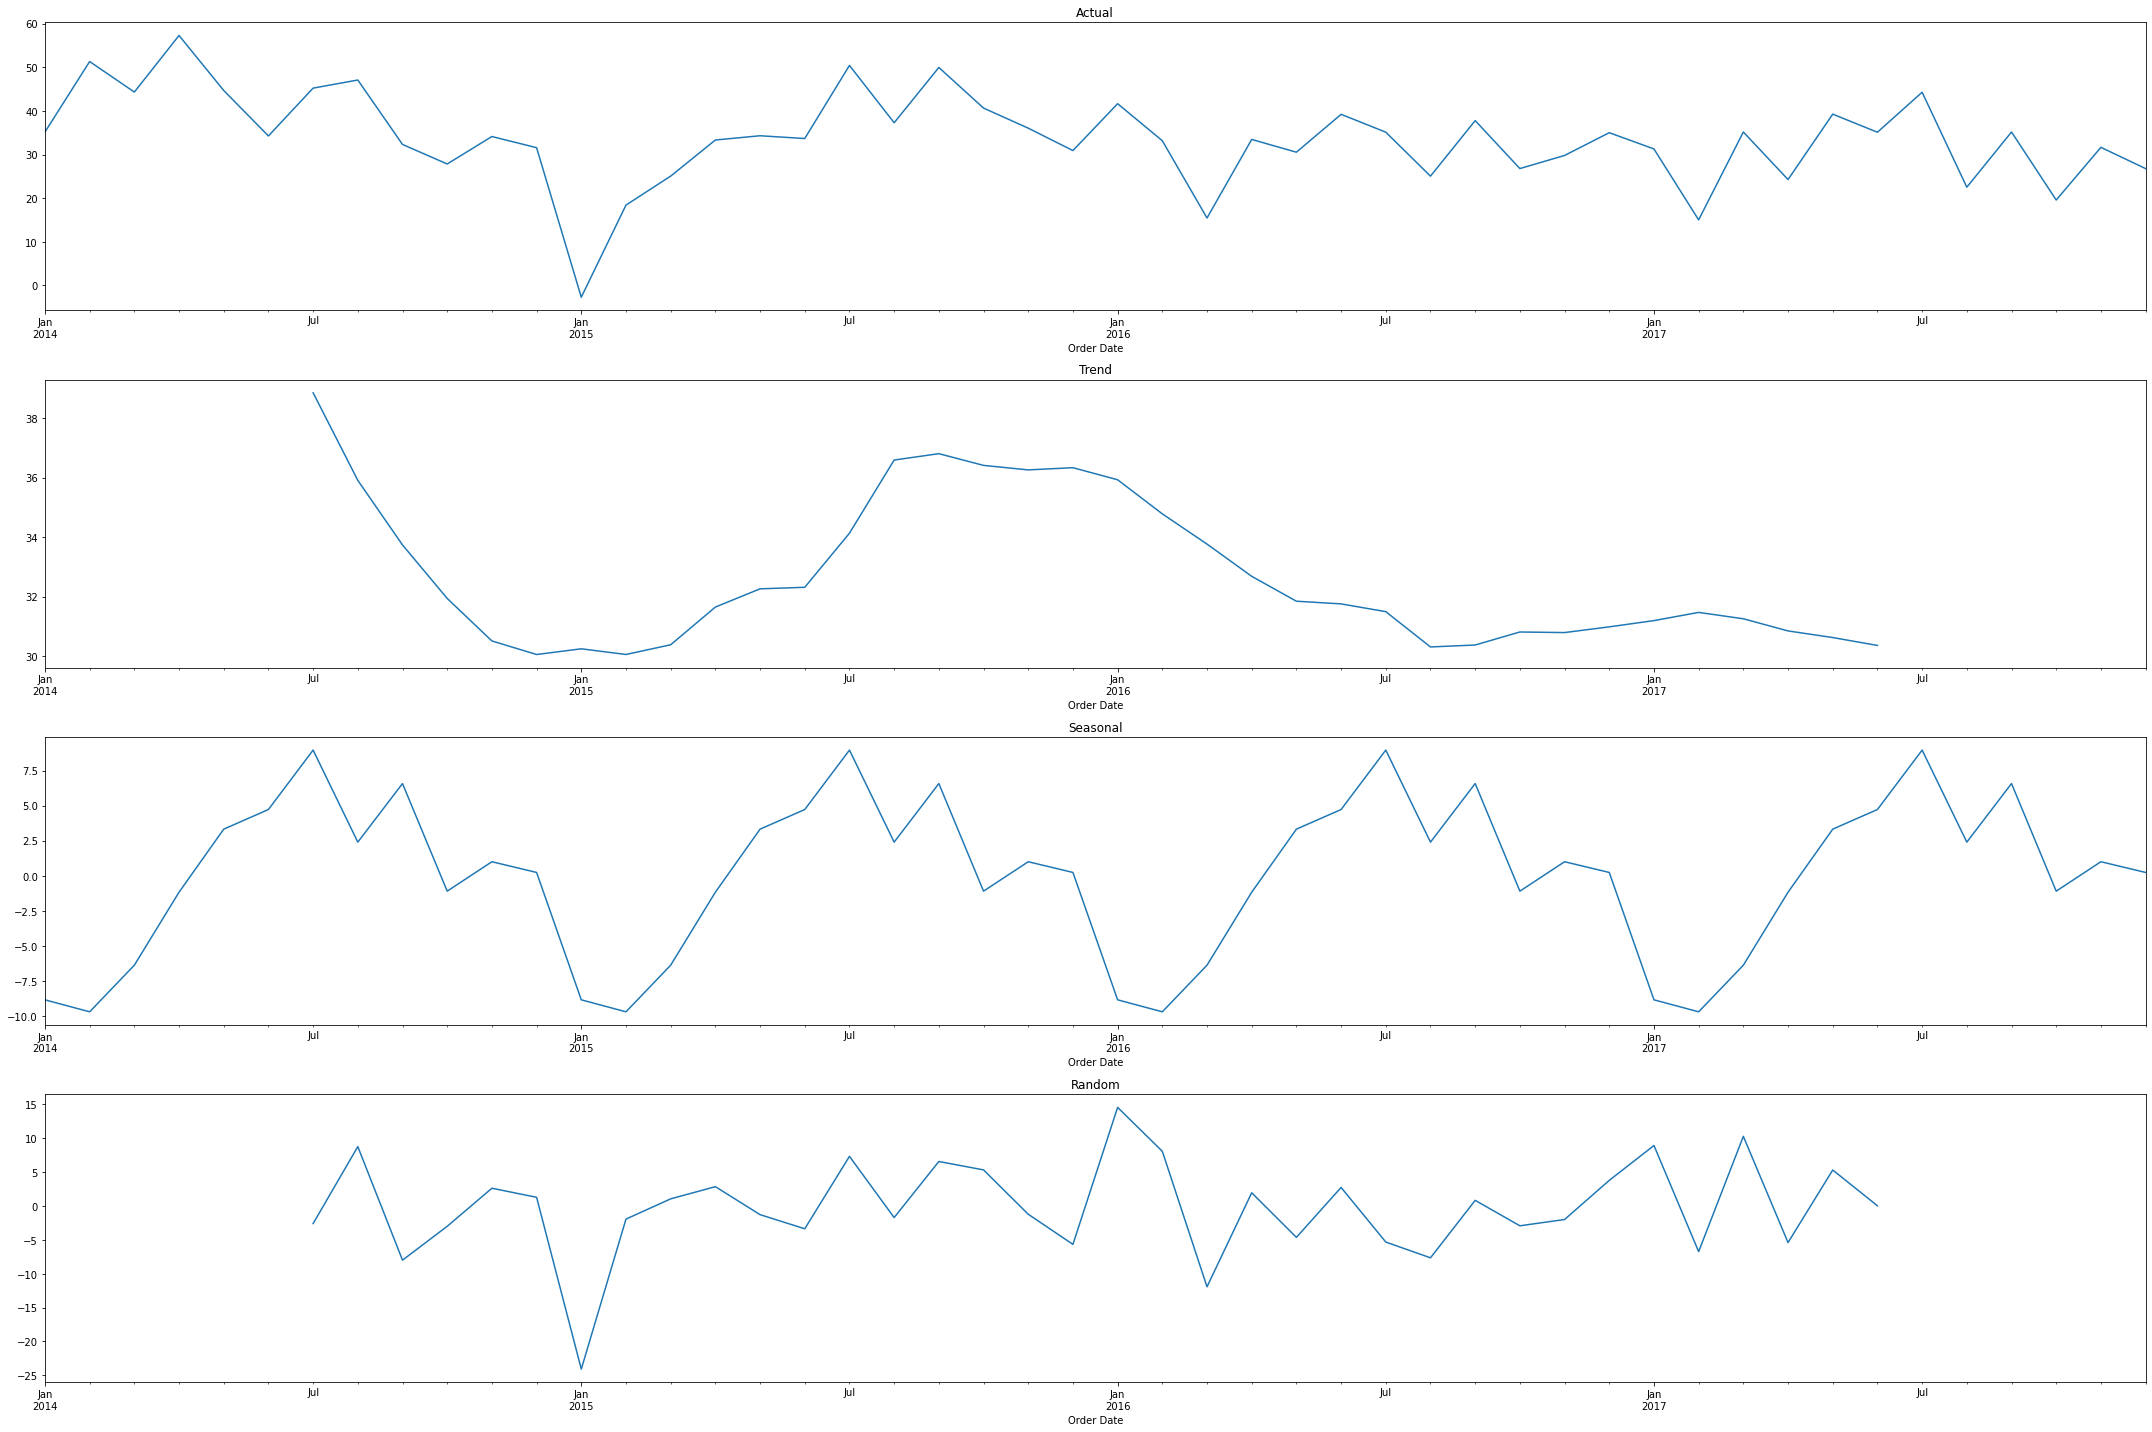

In [416]:
#DECOMPOSITION OF DATA
fig,ax = plt.subplots(4,1,figsize=(30,20))

result = seasonal_decompose(df1_t_profit, period=12)

result.observed.plot(ax=ax[0])
ax[0].set_title("Actual")

result.trend.plot(ax=ax[1])
ax[1].set_title("Trend")

result.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonal")

result.resid.plot(ax=ax[3])
ax[3].set_title("Random")

fig.tight_layout()

plt.show()

There is decreasing trend and seasonality in data.

##### SPLITTING DATASET INTO 70 % TRAIN AND 30 % TEST

In [417]:
split= int(round(0.7 * len(df1_t_profit),0))
train_df1=df1_t_profit.iloc[:split]
test_df1=df1_t_profit.iloc[split:]
print(train_df1.shape,test_df1.shape)
train_df1.head(2),test_df1.head(2)

(34, 1) (14, 1)


(               Profit
 Order Date           
 2014-01-31  35.164433
 2014-02-28  51.315671,
                Profit
 Order Date           
 2016-11-30  29.795324
 2016-12-31  35.008717)

#### CHECKING FOR STATIONARITY

In [418]:
# Augmented dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [419]:
#TRAINING
r=checkStationarity(train_df1)
print('TRAINING:\n',r)

#TESTING
r=checkStationarity(test_df1)
print(r)
# difference in the data 
diff = test_df1 - test_df1.shift()
print(diff)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff))
diff.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff))
print(diff)
# checking again the differenced data for stationarity
checkStationarity(diff)

TRAINING:
 p-value=0.014285944712412844. Data is stationary
p-value=4.542493153109146e-12. Data is stationary
               Profit
Order Date           
2016-11-30        NaN
2016-12-31   5.213393
2017-01-31  -3.724206
2017-02-28 -16.252586
2017-03-31  20.138177
2017-04-30 -10.895785
2017-05-31  14.988727
2017-06-30  -4.148193
2017-07-31   9.168625
2017-08-31 -21.760121
2017-09-30  12.648860
2017-10-31 -15.590320
2017-11-30  12.070003
2017-12-31  -4.867725
Before removing Nulls,total records =  14
After removing Nulls, total records =  13
               Profit
Order Date           
2016-12-31   5.213393
2017-01-31  -3.724206
2017-02-28 -16.252586
2017-03-31  20.138177
2017-04-30 -10.895785
2017-05-31  14.988727
2017-06-30  -4.148193
2017-07-31   9.168625
2017-08-31 -21.760121
2017-09-30  12.648860
2017-10-31 -15.590320
2017-11-30  12.070003
2017-12-31  -4.867725


'p-value=0.00014844840470135625. Data is stationary'

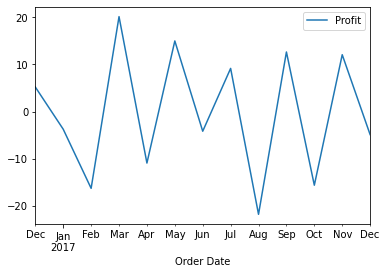

In [420]:
#PLOTTING THE DIFFERENCED DATA FOR TEST DATA
diff.plot()
plt.show()

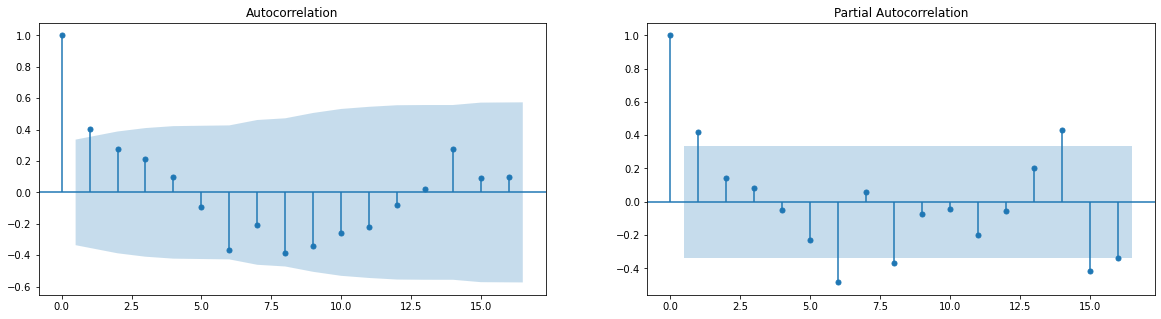

In [421]:
#plotting ACF and PACF plots
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(train_df1,ax=ax[0])
plot_pacf(train_df1,ax=ax[1])
plt.show()

#### SARIMA MODEL

In [422]:
#FINDING THE BEST P,Q,D VALUES
aic=[]
llf=[]
for p in range(0,3):
    for q in range(0,3):
        for d in range(0,2):
            print(p,d,q)
            m2 = sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
            aic.append(m2.aic)
            llf.append(m2.llf)
            m2.summary()
            print('AIC=',m2.aic,'LLR=',m2.llf)      

0 0 0
AIC= 343.5815827910692 LLR= -170.7907913955346
0 1 0
AIC= 179.67406414233963 LLR= -88.83703207116982
0 0 1
AIC= 307.9045258791597 LLR= -150.95226293957984
0 1 1
AIC= 177.70055121102303 LLR= -85.85027560551151
0 0 2
AIC= 295.1270478985306 LLR= -142.5635239492653
0 1 2
AIC= 181.12805238331202 LLR= -85.56402619165601
1 0 0
AIC= 273.62244384282064 LLR= -133.81122192141032
1 1 0
AIC= 180.6382739201562 LLR= -87.3191369600781
1 0 1
AIC= 270.8548573060195 LLR= -130.42742865300974
1 1 1
AIC= 181.54128885318406 LLR= -85.77064442659203
1 0 2
AIC= 274.55013782844827 LLR= -130.27506891422414
1 1 2
AIC= 183.49260647541212 LLR= -84.74630323770606
2 0 0
AIC= 272.544700834684 LLR= -131.272350417342
2 1 0
AIC= 179.47770003923085 LLR= -84.73885001961543
2 0 1
AIC= 274.5676010861168 LLR= -130.2838005430584
2 1 1
AIC= 182.81233376546456 LLR= -84.40616688273228
2 0 2
AIC= 278.3212464131595 LLR= -130.16062320657974
2 1 2
AIC= 185.73395101347654 LLR= -83.86697550673827


In [423]:
max(llf) #-->2,1,2

-83.86697550673827

In [424]:
min(aic) #-->0,1,1

177.70055121102303

Comparison of SARIMA Models:-
    
We choose p=1,d=1,q=1

In [425]:
#PUTTING P,D,Q VALUES
p,d,q=1,1,1
m2= sm.tsa.statespace.SARIMAX(train_df1,order=(p,d,q),seasonal_order=(p,d,q,12)).fit()
print(m2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Profit   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -85.771
Date:                            Tue, 24 May 2022   AIC                            181.541
Time:                                    22:20:38   BIC                            186.764
Sample:                                01-31-2014   HQIC                           182.675
                                     - 10-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1364      0.436      0.313      0.754      -0.717       0.990
ma.L1         -0.6397      0.341   

In [426]:
#PREDICTING THE VALUES
predictions = m2.predict(0,len(test_df1))
print(predictions)

Order Date
2014-01-31     0.000000
2014-02-28    35.162506
2014-03-31    51.313638
2014-04-30    44.320416
2014-05-31    57.283766
2014-06-30    44.682513
2014-07-31    34.264223
2014-08-31    45.223545
2014-09-30    47.081512
2014-10-31    32.318293
2014-11-30    27.844702
2014-12-31    34.133576
2015-01-31    49.158197
2015-02-28    13.469427
2015-03-31     9.587556
Freq: M, Name: predicted_mean, dtype: float64


In [427]:
# actual vs predicted values
actual1 = []; pred1 = []

for i in range(len(test_df1)):
    actual1.append(test_df1.iloc[i][0])
    pred1.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual1, 'predicted':pred1})
df_res1['err'] = df_res1.actual - df_res1.predicted
print(df_res1)

       actual  predicted        err
0   29.795324   0.000000  29.795324
1   35.008717  35.162506  -0.153789
2   31.284511  51.313638 -20.029127
3   15.031925  44.320416 -29.288491
4   35.170102  57.283766 -22.113664
5   24.274317  44.682513 -20.408196
6   39.263044  34.264223   4.998821
7   35.114851  45.223545 -10.108694
8   44.283476  47.081512  -2.798035
9   22.523356  32.318293  -9.794938
10  35.172216  27.844702   7.327513
11  19.581896  34.133576 -14.551680
12  31.651899  49.158197 -17.506299
13  26.784174  13.469427  13.314747


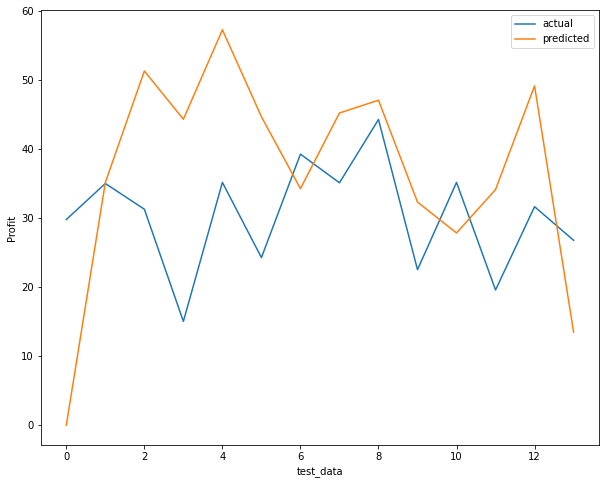

In [428]:
#PLOTTING ACTUAL VS PREDICTED SALES VALUES
df_res1.actual.plot(figsize=(10,8),legend=True)
plt.xlabel('test_data')
plt.ylabel('Profit')
df_res1.predicted.plot(legend=True)
plt.show()

In [429]:
mse2 = mean_squared_error(df_res1.actual,df_res1.predicted)
rmse2=np.sqrt(mse2)
rmse2,mse2

(16.971437609054064, 288.02969451801476)

In [430]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [431]:
fcast1=m2.forecast(len(test_df1))
fcast1

2016-11-30    27.585368
2016-12-31    23.787523
2017-01-31    10.701622
2017-02-28    17.375566
2017-03-31    12.668059
2017-04-30    25.518406
2017-05-31    25.308723
2017-06-30    29.846670
2017-07-31    36.560219
2017-08-31    24.111517
2017-09-30    38.333132
2017-10-31    27.922215
2017-11-30    25.396044
2017-12-31    20.780140
Freq: M, Name: predicted_mean, dtype: float64

In [432]:
mse22 = mean_squared_error(test_df1,fcast1)
rmse22=np.sqrt(mse22)
rmse22,mse22

(10.375868264701177, 107.65864224643302)

In [433]:
#FORCASTING THE FUTURE DATA
fcast1 = m2.predict(start=len(df1_t_profit)-1, end=len(df1_t_profit)+len(test_df1), typ='levels').rename('Forecasted Profit')
print(fcast1)

2017-12-31    20.780140
2018-01-31    22.161005
2018-02-28    19.631458
2018-03-31     7.029521
2018-04-30    23.009430
2018-05-31    21.150820
2018-06-30    28.203389
2018-07-31    28.356890
2018-08-31    17.349557
2018-09-30    30.663380
2018-10-31    19.901148
2018-11-30    19.390725
2018-12-31    15.271534
2019-01-31     7.868401
2019-02-28    10.927071
2019-03-31     3.118511
Freq: M, Name: Forecasted Profit, dtype: float64


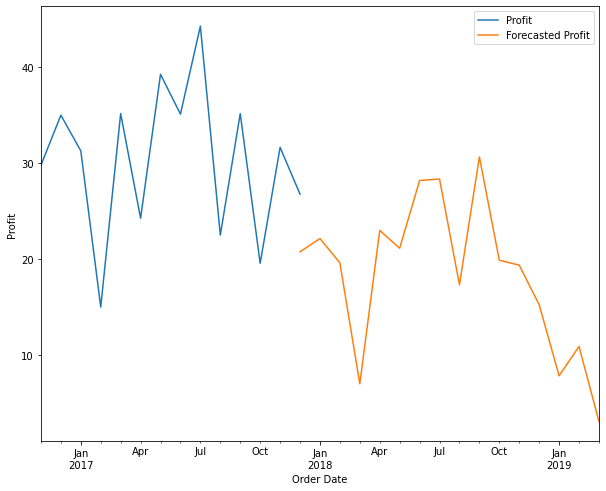

In [434]:
#VISUALIZING THE FORECASTED DATA
test_df1.plot(figsize=(10,8),legend=True)
plt.ylabel('Profit')
fcast1.plot(legend=True)
plt.show()